In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 1. 환경 설정(Environment Setting)

## 1.1 Library Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
from pathlib import Path
import numpy as np
np.random.seed(0)
import pandas as pd
import math
import gc, os, time
import scipy as sp
import statsmodels.api as sm
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold, SelectFromModel, RFE, RFECV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor


## 1.2 모델 성능을 확인하기 위한 함수

In [3]:
# 모듈 설치
!pip install teddynote -q
from teddynote import utils

# 그래프 사이즈 설정
utils.set_plot_options(figsize=(10, 4))

# MSE 에러 설정
utils.set_plot_error('rmse')

df_results = pd.DataFrame()

## 1.3 DataFrame Option 설정

In [4]:
pd.set_option("display.max_colwidth", 999)  # 컬럼 정보 보여주기
pd.set_option("display.max_rows", 150)  # row 정보 보여주기
# pd.reset_option("display.max_colwidth")
# 참고 : https://pandas.pydata.org/docs/user_guide/options.html

# 2. 데이타 읽기(Data Loading)

## 2.1 데이타 읽기

In [5]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
train = pd.read_csv(data_dir / "train.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
test = pd.read_csv(data_dir / "test.csv") # pd.read_csv(data_dir / "test.csv", index_col="Id")

In [6]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
list(test['Street'].value_counts().index)

['Pave', 'Grvl']

## 2.2 데이타 설명

In [10]:
# Dataframe의 데이타 구성 특성을 조회한다.
def rstr(df, pred=None): 
    
    obs = df.shape[0]
    types = df.dtypes # 자료형 
    counts = df.apply(lambda x: x.count()) # 값의 갯수 
    uniques = df.apply(lambda x: x.unique()) # 고유값 
    distincts = df.apply(lambda x: x.unique().shape[0]) # 고유값의 갯수 
    nulls = df.apply(lambda x: x.isnull().sum()) # 결측치의 갯수  
    nulls_ratio = (df.isnull().sum()/ obs) * 100 # 결측 비율 
    skewness = df.skew() # 왜도  
    kurtosis = df.kurt() # 첨도  
    
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis', corr_col ]

    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',dtypes)
    print('___________________________')
    
    return str

In [11]:
details = rstr(train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,nulls_ratio,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000000,"[208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000, 129500, 345000, 144000, 279500, 157000, 132000, 149000, 90000, 159000, 139000, 325300, 139400, 230000, 154000, 256300, 134800, 306000, 207500, 68500, 40000, 149350, 179900, 165500, 277500, 309000, 145000, 153000, 109000, 82000, 160000, 170000, 130250, 141000, 319900, 239686, 249700, 113000, 127000, 177000, 114500, 110000, 385000, 130000, 180500, 172500, 196500, 438780, 124900, 158000, 101000, 202500, 219500, 317000, 180000, 226000, 80000, 225000, 244000, 185000, 144900, 107400, 91000, 135750, 136500, 193500, 153500, 245000, 126500, 168500, 260000, 174000, 164500, 85000, 123600, 109900, 98600, 163500, 133900, 204750, 214000, 94750, 83000, 128950, 205000, 178000, 118964, 198900, 169500, 100000, 115000, ...]",1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.000000,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.000000,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912, 1494, 1253, 854, 1004, 1296, 1114, 1339, 2376, 1108, 1795, 1060, 1600, 900, 1704, 520, 1317, 1228, 1234, 1700, 1561, 2452, 1097, 1297, 1057, 1152, 1324, 1328, 884, 938, 1150, 1752, 2149, 1656, 1452, 955, 1470, 1176, 816, 1842, 1360, 1425, 1739, 1720, 2945, 780, 1158, 1111, 1370, 2034, 2473, 2207, 1479, 747, 2287, 2223, 845, 1718, 1086, 1605, 988, 952, 1285, 1768, 1230, 2142, 1337, 1563, 1065, 1474, 2417, 1560, 1224, 1526, 990, 1235, 964, 2291, 1588, 960, 835, 1225, 1610, 1732, 1535, 1226, 1818, 1992, ...]",1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.000000,"[2, 3, 1, 0, 4]",-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.000000,"[548, 460, 608, 642, 836, 480, 636, 484, 468, 205, 384, 736, 352, 840, 576, 516, 294, 853, 280, 534, 572, 270, 890, 772, 319, 240, 250, 271, 447, 556, 691, 672, 498, 246, 0, 440, 308, 504, 300, 670, 826, 386, 388, 528, 894, 565, 641, 288, 645, 852, 558, 220, 667, 360, 427, 490, 379, 297, 283, 509, 405, 758, 461, 400, 462, 420, 432, 506, 684, 472, 366, 476, 410, 740, 648, 273, 546, 325, 792, 450, 180, 430, 594, 390, 540, 264, 530, 435, 453, 750, 487, 624, 471, 318, 766, 660, 470, 720, 577, 380, ...]",0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,721,0,0.000000,"[856, 1262, 920, 756, 1145, 796, 1686, 1107, 952, 991, 1040, 1175, 912, 1494, 1253, 832, 1004, 0, 1114, 1029, 1158, 637, 1777, 1060, 1566, 900, 1704, 1484, 520, 649, 1228, 1234, 1398, 1561, 1117, 1097, 1297, 1057, 1088, 1350, 840, 938, 1150, 1752, 1434, 1656, 736, 955, 794, 816, 1842, 384, 1425, 970, 860, 1410, 780, 530, 1370, 576, 1143, 1947, 1453, 747, 1304, 2223, 845, 1086, 462, 672, 1768, 440, 896, 1237, 1563, 1065, 1288, 684, 612, 1013, 990, 1235, 876, 1214, 824, 680, 1588, 960, 458, 950, 1610, 741, 1226, 1053, 641, 789, 793, 1844, 994, 1264, ...]",1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.000000,"[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1022, 1077, 1040, 1182, 912, 1494, 1253, 854, 1004, 1296, 1114, 1339, 1158, 1108, 1795, 1060, 1600, 900, 1704, 520, 649, 1228, 1234, 1700, 1561, 1132, 1097, 1297, 1057, 1152, 1324, 1328, 884, 938, 1150, 1752, 1518, 1656, 736, 955, 794, 816, 1842, 1360, 1425, 983, 860, 1426, 780, 581, 1370, 902, 1143, 2207, 1479, 747, 1304, 2223, 845, 885, 1086, 840, 526, 952, 1072, 1768, 682, 1337, 1563, 1065, 804, 1301, 684, 612, 1013, 990, 1235, 964, 1260, 905, 680, 1588, 960, 835, 1225, 1610, 977, 1535, 1226, 1053, 1047, 789, ...]",1.376757,5.745841,0.605852
FullBath,int64,1460,4,0,0.000000,"[2, 1, 3, 0]",0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,12,0,0.000000,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]",0.676341,0.880762,0.533723
YearBuilt,int64,1460,112,0,0.000000,"[2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965, 2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968, 2007, 1951, 1957, 1927, 1920, 1966, 1959

In [12]:
# Train, Test Feature 특성 비교하기
def compare_cols(df_train, df_test, target='y'):
    ''' train vs test information compare '''
    
    # train의 target column을 제외하여 Test의 column과 동일하게 처리
    df_train_drop = df_train.drop(target, axis=1)
    
    train_obs = df_train_drop.shape[0]
    train_types = df_train_drop.dtypes # 자료형 
    train_counts = df_train_drop.apply(lambda x: x.count()) # 값의 갯수 
    train_uniques = df_train_drop.apply(lambda x: x.unique()) # 고유값 
    train_distincts = df_train_drop.apply(lambda x: x.unique().shape[0]) # 고유값의 갯수 
    train_nulls = df_train_drop.apply(lambda x: x.isnull().sum()) # 결측치의 갯수  
    train_nulls_ratio = (df_train_drop.isnull().sum()/ train_obs) * 100 # 결측 비율 
    train_skewness = df_train_drop.skew() # 왜도  
    train_kurtosis = df_train_drop.kurt() # 첨도  
    
    test_obs = df_test.shape[0]
    test_types = df_test.dtypes # 자료형 
    test_counts = df_test.apply(lambda x: x.count()) # 값의 갯수 
    test_uniques = df_test.apply(lambda x: x.unique()) # 고유값 
    test_distincts = df_test.apply(lambda x: x.unique().shape[0]) # 고유값의 갯수 
    test_nulls = df_test.apply(lambda x: x.isnull().sum()) # 결측치의 갯수  
    test_nulls_ratio = (df_test.isnull().sum()/ test_obs) * 100 # 결측 비율 
    test_skewness = df_test.skew() # 왜도  
    test_kurtosis = df_test.kurt() # 첨도  
    
    cols = ['types', 't_types', 'same_type', 'counts', 't_counts', 'nulls', 't_nulls', 'nulls_ratio', 't_null_ratio', 
            'distincts', 't_distincts', 'uniques', 't_uniques', 'skew', 't_skew', 'kurtosis', 't_kurtosis']
    str = pd.concat([train_types, test_types, train_types == test_types, train_counts, test_counts, train_nulls, test_nulls, train_nulls_ratio, test_nulls_ratio, 
                     train_distincts, test_distincts, train_uniques, test_uniques, train_skewness, test_skewness, train_kurtosis, test_kurtosis], axis = 1)

    str.columns = cols

    return str

In [13]:
df_comp = compare_cols(train, test, 'SalePrice')
display(df_comp.sort_values(['same_type','nulls_ratio','t_null_ratio'], ascending=[True, False,False]))

,types,t_types,same_type,counts,t_counts,nulls,t_nulls,nulls_ratio,t_null_ratio,distincts,t_distincts,uniques,t_uniques,skew,t_skew,kurtosis,t_kurtosis
BsmtFullBath,int64,float64,False,1460,1457,0,2,0.000000,0.137080,4,5,"[1, 0, 2, 3]","[0.0, 1.0, 2.0, 3.0, nan]",0.596067,0.649698,-0.839098,-0.644984
BsmtHalfBath,int64,float64,False,1460,1457,0,2,0.000000,0.137080,3,4,"[0, 1, 2]","[0.0, 1.0, nan, 2.0]",4.103403,3.779866,16.396642,13.550835
BsmtFinSF1,int64,float64,False,1460,1458,0,1,0.000000,0.068540,637,670,"[706, 978, 486, 216, 655, 732, 1369, 859, 0, 851, 906, 998, 737, 733, 578, 646, 504, 840, 188, 234, 1218, 1277, 1018, 1153, 1213, 731, 643, 967, 747, 280, 179, 456, 1351, 24, 763, 182, 104, 1810, 384, 490, 649, 632, 941, 739, 912, 1013, 603, 1880, 565, 320, 462, 228, 336, 448, 1201, 33, 588, 600, 713, 1046, 648, 310, 1162, 520, 108, 569, 1200, 224, 705, 444, 250, 984, 35, 774, 419, 170, 1470, 938, 570, 300, 120, 116, 512, 567, 445, 695, 405, 1005, 668, 821, 432, 1300, 507, 679, 1332, 209, 680, 716, 1400, 416, ...]","[468.0, 923.0, 791.0, 602.0, 263.0, 0.0, 935.0, 637.0, 804.0, 1051.0, 156.0, 300.0, 514.0, 110.0, 28.0, 1373.0, 578.0, 24.0, 16.0, 326.0, 1414.0, 126.0, 250.0, 1129.0, 1298.0, 280.0, 368.0, 376.0, 466.0, 244.0, 1032.0, 484.0, 833.0, 506.0, 1137.0, 687.0, 329.0, 698.0, 1059.0, 1010.0, 1500.0, 670.0, 944.0, 1188.0, 856.0, 936.0, 734.0, 339.0, 648.0, 532.0, 481.0, 588.0, 717.0, 48.0, 579.0, 274.0, 780.0, 176.0, 283.0, 788.0, 474.0, 188.0, 452.0, 264.0, 360.0, 276.0, 448.0, 960.0, 766.0, 1026.0, 73.0, 736.0, 704.0, 240.0, 775.0, 1319.0, 267.0, 1092.0, 964.0, 288.0, 104.0, 192.0, 954.0, 1346.0, 1433.0, 860.0, 870.0, 353.0, 198.0, 480.0, 1682.0, 672.0, 1070.0, 528.0, 133.0, 238.0, 426.0, 375.0, 343.0, 747.0, ...]",1.685503,1.165677,11.118236,2.672966
BsmtFinSF2,int64,float64,False,1460,1458,0,1,0.000000,0.068540,144,162,"[0, 32, 668, 486, 93, 491, 506, 712, 362, 41, 169, 869, 150, 670, 28, 1080, 181, 768, 215, 374, 208, 441, 184, 279, 306, 180, 580, 690, 692, 228, 125, 1063, 620, 175, 820, 1474, 264, 479, 147, 232, 380, 544, 294, 258, 121, 391, 531, 344, 539, 713, 210, 311, 1120, 165, 532, 96, 495, 174, 1127, 139, 202, 645, 123, 551, 219, 606, 612, 480, 182, 132, 336, 468, 287, 35, 499, 723, 119, 40, 117, 239, 80, 472, 64, 1057, 127, 630, 128, 377, 764, 345, 1085, 435, 823, 500, 290, 324, 634, 411, 841, 1061, ...]","[144.0, 0.0, 78.0, 859.0, 981.0, 42.0, 46.0, 162.0, 174.0, 350.0, 263.0, 1073.0, 12.0, 159.0, 474.0, 453.0, 684.0, 387.0, 688.0, 252.0, 590.0, 284.0, 276.0, 168.0, 294.0, 622.0, 113.0, 1526.0, 360.0, 774.0, 364.0, 596.0, 884.0, 92.0, 216.0, 136.0, 147.0, 201.0, 512.0, 247.0, 202.0, 483.0, 750.0, 60.0, 102.0, 95.0, 63.0, 262.0, 393.0, 286.0, 450.0, 72.0, 243.0, 694.0, 875.0, 507.0, 435.0, 419.0, 250.0, 116.0, 624.0, 76.0, 270.0, 110.0, 288.0, 186.0, 449.0, 48.0, 613.0, 495.0, 852.0, 555.0, 799.0, 811.0, 842.0, 670.0, 382.0, 456.0, 308.0, 52.0, 196.0, 128.0, 488.0, 319.0, 273.0, nan, 240.0, 956.0, 723.0, 120.0, 679.0, 40.0, 121.0, 604.0, 153.0, 619.0, 6.0, 351.0, 1037.0, 829.0, ...]",4.255261,4.041345,20.113338,17.667230
BsmtUnfSF,int64,float64,False,1460,1458,0,1,0.000000,0.068540,780,794,"[150, 284, 434, 540, 490, 64, 317, 216, 952, 140, 134, 177, 175, 1494, 520, 832, 426, 0, 468, 525, 1158, 637, 1777, 200, 204, 1566, 180, 486, 207, 649, 1228, 1234, 380, 408, 1117, 1097, 84, 326, 445, 383, 167, 465, 1296, 83, 1632, 736, 192, 612, 816, 32, 935, 321, 860, 1410, 148, 217, 530, 1346, 576, 318, 1143, 1035, 440, 747, 701, 343, 280, 404, 840, 724, 295, 1768, 448, 36, 1530, 1065, 384, 1288, 684, 1013, 402, 635, 163, 168, 176, 370, 350, 381, 410, 741, 1226, 1053, 641, 516, 793, 1139, 550, 905, 104, 310, ...]","[270.0, 406.0, 137.0, 324.0, 1017.0, 763.0, 233.0, 789.0, 663.0, 0.0, 354.0, 327.0, 225.0, 341.0, 836.0, 1590.0, 1544.0, 1588.0, 1794.0, 1473.0, 1093.0, 1346.0, 1324.0, 1129.0, 58.0, 847.0, 1629.0, 1595.0, 1218.0, 54.0, 831.0, 816.0, 223.0, 261.0, 190.0, 840.0, 320.0, 224.0, 290.0, 286.0, 610.0, 491.0, 659

In [14]:
# skew train data > 0.5
condt = abs(df_comp['skew']) > 0.35   # 0.4 vs 0.35 same
col_skewed_0point5 = set(df_comp.loc[condt].index)
print(col_skewed_0point5)

{'LotArea', '2ndFlrSF', 'TotalBsmtSF', 'MSSubClass', 'EnclosedPorch', 'BsmtFullBath', 'BsmtFinSF2', '3SsnPorch', '1stFlrSF', 'WoodDeckSF', 'LowQualFinSF', 'BsmtUnfSF', 'TotRmsAbvGrd', 'OverallCond', 'GrLivArea', 'GarageYrBlt', 'Fireplaces', 'BsmtHalfBath', 'MasVnrArea', 'ScreenPorch', 'YearRemodAdd', 'OpenPorchSF', 'BsmtFinSF1', 'PoolArea', 'LotFrontage', 'YearBuilt', 'MiscVal', 'KitchenAbvGr', 'HalfBath'}


In [15]:
# skew predict data > 0.5
condp = abs(df_comp['t_skew']) > 0.35  # 0.4 vs 0.35 same
tcol_skewed_0point5 = set(df_comp.loc[condp].index)
print(tcol_skewed_0point5)

{'LotArea', '2ndFlrSF', 'TotalBsmtSF', 'MSSubClass', 'EnclosedPorch', 'BsmtFullBath', 'BsmtFinSF2', 'BedroomAbvGr', '3SsnPorch', '1stFlrSF', 'WoodDeckSF', 'LowQualFinSF', 'BsmtUnfSF', 'TotRmsAbvGrd', 'OverallCond', 'GrLivArea', 'Fireplaces', 'BsmtHalfBath', 'MasVnrArea', 'ScreenPorch', 'YearRemodAdd', 'OpenPorchSF', 'BsmtFinSF1', 'PoolArea', 'LotFrontage', 'YearBuilt', 'MiscVal', 'KitchenAbvGr', 'HalfBath'}


In [16]:
# skew train union predict data > 0.5
col_union_skewed_0point5 = col_skewed_0point5 | tcol_skewed_0point5
print(col_union_skewed_0point5)

{'LotArea', '2ndFlrSF', 'TotalBsmtSF', 'MSSubClass', 'EnclosedPorch', 'BsmtFullBath', 'BsmtFinSF2', 'BedroomAbvGr', '3SsnPorch', '1stFlrSF', 'WoodDeckSF', 'LowQualFinSF', 'BsmtUnfSF', 'TotRmsAbvGrd', 'OverallCond', 'GrLivArea', 'GarageYrBlt', 'Fireplaces', 'BsmtHalfBath', 'MasVnrArea', 'ScreenPorch', 'YearRemodAdd', 'OpenPorchSF', 'BsmtFinSF1', 'PoolArea', 'LotFrontage', 'YearBuilt', 'MiscVal', 'KitchenAbvGr', 'HalfBath'}


In [17]:
# 조회 기본 조건
cond1 = df_comp['same_type'] == False # type이 다르다
cond2 = df_comp['types']     == object # type이 'object' 이다.

In [18]:
cond = cond1
df_comp.loc[cond]

,types,t_types,same_type,counts,t_counts,nulls,t_nulls,nulls_ratio,t_null_ratio,distincts,t_distincts,uniques,t_uniques,skew,t_skew,kurtosis,t_kurtosis
BsmtFinSF1,int64,float64,False,1460,1458,0,1,0.0,0.06854,637,670,"[706, 978, 486, 216, 655, 732, 1369, 859, 0, 851, 906, 998, 737, 733, 578, 646, 504, 840, 188, 234, 1218, 1277, 1018, 1153, 1213, 731, 643, 967, 747, 280, 179, 456, 1351, 24, 763, 182, 104, 1810, 384, 490, 649, 632, 941, 739, 912, 1013, 603, 1880, 565, 320, 462, 228, 336, 448, 1201, 33, 588, 600, 713, 1046, 648, 310, 1162, 520, 108, 569, 1200, 224, 705, 444, 250, 984, 35, 774, 419, 170, 1470, 938, 570, 300, 120, 116, 512, 567, 445, 695, 405, 1005, 668, 821, 432, 1300, 507, 679, 1332, 209, 680, 716, 1400, 416, ...]","[468.0, 923.0, 791.0, 602.0, 263.0, 0.0, 935.0, 637.0, 804.0, 1051.0, 156.0, 300.0, 514.0, 110.0, 28.0, 1373.0, 578.0, 24.0, 16.0, 326.0, 1414.0, 126.0, 250.0, 1129.0, 1298.0, 280.0, 368.0, 376.0, 466.0, 244.0, 1032.0, 484.0, 833.0, 506.0, 1137.0, 687.0, 329.0, 698.0, 1059.0, 1010.0, 1500.0, 670.0, 944.0, 1188.0, 856.0, 936.0, 734.0, 339.0, 648.0, 532.0, 481.0, 588.0, 717.0, 48.0, 579.0, 274.0, 780.0, 176.0, 283.0, 788.0, 474.0, 188.0, 452.0, 264.0, 360.0, 276.0, 448.0, 960.0, 766.0, 1026.0, 73.0, 736.0, 704.0, 240.0, 775.0, 1319.0, 267.0, 1092.0, 964.0, 288.0, 104.0, 192.0, 954.0, 1346.0, 1433.0, 860.0, 870.0, 353.0, 198.0, 480.0, 1682.0, 672.0, 1070.0, 528.0, 133.0, 238.0, 426.0, 375.0, 343.0, 747.0, ...]",1.685503,1.165677,11.118236,2.672966
BsmtFinSF2,int64,float64,False,1460,1458,0,1,0.0,0.06854,144,162,"[0, 32, 668, 486, 93, 491, 506, 712, 362, 41, 169, 869, 150, 670, 28, 1080, 181, 768, 215, 374, 208, 441, 184, 279, 306, 180, 580, 690, 692, 228, 125, 1063, 620, 175, 820, 1474, 264, 479, 147, 232, 380, 544, 294, 258, 121, 391, 531, 344, 539, 713, 210, 311, 1120, 165, 532, 96, 495, 174, 1127, 139, 202, 645, 123, 551, 219, 606, 612, 480, 182, 132, 336, 468, 287, 35, 499, 723, 119, 40, 117, 239, 80, 472, 64, 1057, 127, 630, 128, 377, 764, 345, 1085, 435, 823, 500, 290, 324, 634, 411, 841, 1061, ...]","[144.0, 0.0, 78.0, 859.0, 981.0, 42.0, 46.0, 162.0, 174.0, 350.0, 263.0, 1073.0, 12.0, 159.0, 474.0, 453.0, 684.0, 387.0, 688.0, 252.0, 590.0, 284.0, 276.0, 168.0, 294.0, 622.0, 113.0, 1526.0, 360.0, 774.0, 364.0, 596.0, 884.0, 92.0, 216.0, 136.0, 147.0, 201.0, 512.0, 247.0, 202.0, 483.0, 750.0, 60.0, 102.0, 95.0, 63.0, 262.0, 393.0, 286.0, 450.0, 72.0, 243.0, 694.0, 875.0, 507.0, 435.0, 419.0, 250.0, 116.0, 624.0, 76.0, 270.0, 110.0, 288.0, 186.0, 449.0, 48.0, 613.0, 495.0, 852.0, 555.0, 799.0, 811.0, 842.0, 670.0, 382.0, 456.0, 308.0, 52.0, 196.0, 128.0, 488.0, 319.0, 273.0, nan, 240.0, 956.0, 723.0, 120.0, 679.0, 40.0, 121.0, 604.0, 153.0, 619.0, 6.0, 351.0, 1037.0, 829.0, ...]",4.255261,4.041345,20.113338,17.667230
BsmtUnfSF,int64,float64,False,1460,1458,0,1,0.0,0.06854,780,794,"[150, 284, 434, 540, 490, 64, 317, 216, 952, 140, 134, 177, 175, 1494, 520, 832, 426, 0, 468, 525, 1158, 637, 1777, 200, 204, 1566, 180, 486, 207, 649, 1228, 1234, 380, 408, 1117, 1097, 84, 326, 445, 383, 167, 465, 1296, 83, 1632, 736, 192, 612, 816, 32, 935, 321, 860, 1410, 148, 217, 530, 1346, 576, 318, 1143, 1035, 440, 747, 701, 343, 280, 404, 840, 724, 295, 1768, 448, 36, 1530, 1065, 384, 1288, 684, 1013, 402, 635, 163, 168, 176, 370, 350, 381, 410, 741, 1226, 1053, 641, 516, 793, 1139, 550, 905, 104, 310, ...]","[270.0, 406.0, 137.0, 324.0, 1017.0, 763.0, 233.0, 789.0, 663.0, 0.0, 354.0, 327.0, 225.0, 341.0, 836.0, 1590.0, 1544.0, 1588.0, 1794.0, 1473.0, 1093.0, 1346.0, 1324.0, 1129.0, 58.0, 847.0, 1629.0, 1595.0, 1218.0, 54.0, 831.0, 816.0, 223.0, 261.0, 190.0, 840.0, 320.0, 224.0, 290.0, 286.0, 610.0, 491.0, 659.0, 1323.0, 143.0, 386.0, 534.0, 150.0, 500.0, 533.0, 228.0, 470.0, 482.0, 136.0, 1604.0, 292.0, 125.0, 510.0, 832.0, 525.0, 456.0, 576.0, 161.0, 237.0, 415.0, 661.0, 357.0, 827.0, 247.0, 678.0, 930.0, 346.0, 455.0, 200.0, 634.0, 577.0, 144.0, 308.0, 316.0, 480.0, 252.0, 164.0, 888.0, 780.0, 662.0, 656.0, 689

In [19]:
cond = ~(cond1) & (cond2)
df_comp.loc[cond]

,types,t_types,same_type,counts,t_counts,nulls,t_nulls,nulls_ratio,t_null_ratio,distincts,t_distincts,uniques,t_uniques,skew,t_skew,kurtosis,t_kurtosis
MSZoning,object,object,True,1460,1455,0,4,0.000000,0.274160,5,6,"[RL, RM, C (all), FV, RH]","[RH, RL, RM, FV, C (all), nan]",NaN,NaN,NaN,NaN
Street,object,object,True,1460,1459,0,0,0.000000,0.000000,2,2,"[Pave, Grvl]","[Pave, Grvl]",NaN,NaN,NaN,NaN
Alley,object,object,True,91,107,1369,1352,93.767123,92.666210,3,3,"[nan, Grvl, Pave]","[nan, Pave, Grvl]",NaN,NaN,NaN,NaN
LotShape,object,object,True,1460,1459,0,0,0.000000,0.000000,4,4,"[Reg, IR1, IR2, IR3]","[Reg, IR1, IR2, IR3]",NaN,NaN,NaN,NaN
LandContour,object,object,True,1460,1459,0,0,0.000000,0.000000,4,4,"[Lvl, Bnk, Low, HLS]","[Lvl, HLS, Bnk, Low]",NaN,NaN,NaN,NaN
Utilities,object,object,True,1460,1457,0,2,0.000000,0.137080,2,2,"[AllPub, NoSeWa]","[AllPub, nan]",NaN,NaN,NaN,NaN
LotConfig,object,object,True,1460,1459,0,0,0.000000,0.000000,5,5,"[Inside, FR2, Corner, CulDSac, FR3]","[Inside, Corner, FR2, CulDSac, FR3]",NaN,NaN,NaN,NaN
LandSlope,object,object,True,1460,1459,0,0,0.000000,0.000000,3,3,"[Gtl, Mod, Sev]","[Gtl, Mod, Sev]",NaN,NaN,NaN,NaN
Neighborhood,object,object,True,1460,1459,0,0,0.000000,0.000000,25,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW, IDOTRR, MeadowV, Edwards, Timber, Gilbert, StoneBr, ClearCr, NPkVill, Blmngtn, BrDale, SWISU, Blueste]","[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown, BrkSide, ClearCr, SWISU, Edwards, CollgCr, Crawfor, Blueste, IDOTRR, Mitchel, Timber, MeadowV, Veenker]",NaN,NaN,NaN,NaN
Condition1,object,object,True,1460,1459,0,0,0.000000,0.000000,9,9,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, PosA, RRNe]","[Feedr, Norm, PosN, RRNe, Artery, RRNn, PosA, RRAn, RRAe]",NaN,NaN,NaN,NaN


In [20]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(None, None)

# 3. 탐색적 데이타분석 (EDA)

## 3.1 탐색적 데이타분석 준비

### 1) Train Data 기초 분석

In [21]:
%%time

# EDA를 위한 학습 데이터를 복사합니다.
df_eda = train.copy()

CPU times: user 670 µs, sys: 0 ns, total: 670 µs
Wall time: 678 µs


In [22]:
# 숫자형 데이타 특징 조회하기
df_eda.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [23]:
# 무 결측치 숫자형 컬럼 정보
col_nona_numerical = list(df_eda.describe().T[df_eda.describe().T['count'] == df_eda.shape[0]].T.columns)
print(col_nona_numerical)
# 무 결측치 데이타 분포 점검하기
df_eda.describe().T[df_eda.describe().T['count'] == df_eda.shape[0]].T

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [24]:
# 유 결측치 숫자형 컬럼 정보
col_hasna_numerical = list(df_eda.describe().T[df_eda.describe().T['count'] < df_eda.shape[0]].T.columns)
print(col_hasna_numerical)
# 유 결측치 데이타 분포 점검하기
df_eda.describe().T[df_eda.describe().T['count'] < df_eda.shape[0]].T

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [25]:
df_eda.describe().T[df_eda.describe().T['count'] < df_eda.shape[0]][['mean','max','75%']].T
# df_eda.describe().T[df_eda.describe().T['count'] < df_eda.shape[0]]['75%'].T['LotFrontage']

,LotFrontage,MasVnrArea,GarageYrBlt
mean,70.049958,103.685262,1978.506164
max,313.000000,1600.000000,2010.000000
75%,80.000000,166.000000,2002.000000


In [26]:
# Object 데이타 특징 조회하기
df_eda.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [27]:
# 무 결측치 object형 컬럼 정보
col_nona_object = list(df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] == df_eda.shape[0]].T.columns)
print(col_nona_object)
# 무 결측치 Object 데이타 분포 점검하기
df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] == df_eda.shape[0]].T

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,6,6,5,2,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,PConc,GasA,Ex,Y,TA,Typ,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1282,647,1428,741,1365,735,1360,1340,1267,1198


In [28]:
# 유 결측치 object형 컬럼 정보
col_hasna_object = list(df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] < df_eda.shape[0]].T.columns)
print(col_hasna_object)
# 유 결측치 Object 데이타 분포 점검하기
df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] < df_eda.shape[0]].T

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
count,91,1452,1423,1423,1422,1423,1422,1459,770,1379,1379,1379,1379,7,281,54
unique,2,4,4,4,4,6,6,5,5,6,3,5,5,3,4,4
top,Grvl,None,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
freq,50,864,649,1311,953,430,1256,1334,380,870,605,1311,1326,3,157,49


In [29]:
df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] < df_eda.shape[0]]['top'].T
# df_eda.describe(include='object').T[df_eda.describe(include='object').T['count'] < df_eda.shape[0]]['top'].T['Alley']

Alley             Grvl
MasVnrType        None
BsmtQual            TA
BsmtCond            TA
BsmtExposure        No
BsmtFinType1       Unf
BsmtFinType2       Unf
Electrical       SBrkr
FireplaceQu         Gd
GarageType      Attchd
GarageFinish       Unf
GarageQual          TA
GarageCond          TA
PoolQC              Gd
Fence            MnPrv
MiscFeature       Shed
Name: top, dtype: object

### 2) Predict Data 기초 분석

In [30]:
# EDA를 위한 평가 데이터를 복사합니다.
df_eda_predict = test.copy()

In [31]:
# 무 결측치 숫자형 컬럼 정보
col_nona_numerical_predict = list(df_eda_predict.describe().T[df_eda_predict.describe().T['count'] == df_eda_predict.shape[0]].T.columns)
print(col_nona_numerical_predict)
# 무 결측치 데이타 분포 점검하기
df_eda_predict.describe().T[df_eda_predict.describe().T['count'] == df_eda_predict.shape[0]].T

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,9819.161069,6.078821,5.553804,1971.357779,1983.662783,1156.534613,325.967786,3.543523,...,0.58122,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,4955.517327,1.436812,1.113740,30.390071,21.130467,398.165820,420.610226,44.043251,...,0.64742,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,407.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,873.500000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,1079.000000,0.000000,0.000000,...,0.00000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,1382.500000,676.000000,0.000000,...,1.00000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,5095.000000,1862.000000,1064.000000,...,4.00000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [32]:
# 유 결측치 숫자형 컬럼 정보
col_hasna_numerical_predict = list(df_eda_predict.describe().T[df_eda_predict.describe().T['count'] < df_eda_predict.shape[0]].T.columns)
print(col_hasna_numerical_predict)
# 유 결측치 데이타 분포 점검하기
df_eda_predict.describe().T[df_eda_predict.describe().T['count'] < df_eda_predict.shape[0]].T

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
count,1232.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1457.000000,1457.000000,1381.000000,1458.000000,1458.000000
mean,68.580357,100.709141,439.203704,52.619342,554.294925,1046.117970,0.434454,0.065202,1977.721217,1.766118,472.768861
std,22.376841,177.625900,455.268042,176.753926,437.260486,442.898624,0.530648,0.252468,26.431175,0.775945,217.048611
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,219.250000,784.000000,0.000000,0.000000,1959.000000,1.000000,318.000000
50%,67.000000,0.000000,350.500000,0.000000,460.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,480.000000
75%,80.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,200.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000


In [33]:
# 무 결측치 object형 컬럼 정보
col_nona_object_predict = list(df_eda_predict.describe(include='object').T[df_eda_predict.describe(include='object').T['count'] == df_eda_predict.shape[0]].T.columns)
print(col_nona_object_predict)
# 무 결측치 Object 데이타 분포 점검하기
df_eda_predict.describe(include='object').T[df_eda_predict.describe(include='object').T['count'] == df_eda_predict.shape[0]].T

['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'PavedDrive', 'SaleCondition']


,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,RoofMatl,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,Electrical,PavedDrive,SaleCondition
count,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,...,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459
unique,2,4,4,5,3,25,9,5,5,7,...,4,4,5,6,4,5,2,4,3,6
top,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,...,CompShg,TA,TA,PConc,GasA,Ex,Y,SBrkr,Y,Normal
freq,1453,934,1311,1081,1396,218,1251,1444,1205,745,...,1442,892,1256,661,1446,752,1358,1337,1301,1204


In [34]:
# 유 결측치 object형 컬럼 정보
col_hasna_object_predict = list(df_eda_predict.describe(include='object').T[df_eda_predict.describe(include='object').T['count'] < df_eda_predict.shape[0]].T.columns)
print(col_hasna_object_predict)
# 유 결측치 Object 데이타 분포 점검하기
df_eda_predict.describe(include='object').T[df_eda_predict.describe(include='object').T['count'] < df_eda_predict.shape[0]].T

['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


,MSZoning,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
count,1455,107,1457,1458,1458,1443,1415,1414,1415,1417,...,1457,729,1383,1381,1381,1381,3,290,51,1458
unique,5,2,1,13,15,4,4,4,4,6,...,7,5,6,3,4,5,2,4,3,9
top,RL,Grvl,AllPub,VinylSd,VinylSd,None,TA,TA,No,GLQ,...,Typ,Gd,Attchd,Unf,TA,TA,Ex,MnPrv,Shed,WD
freq,1114,70,1457,510,510,878,634,1295,951,431,...,1357,364,853,625,1293,1328,2,172,46,1258


In [35]:
# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
# df_eda[col_time] = df_eda[col_time].apply(pd.to_datetime)

### 3.1.1 결측치 보정 전 신규 Feature 생성

In [36]:
# flag [True, False] categry field 추가
flag_fields = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'PoolQC', 'Fence', 'MiscFeature']

In [37]:
def add_flagfields(df):
    for ffield in flag_fields:
        col_name = 'gen_existflag_' + ffield
        if not col_name in df.columns:
            #df[col_name] = df[ffield].notna()     # Boolean type
            df[col_name] = df[ffield].apply(lambda x : 1 if type(x) == type('str') else 0)  # 1, 0 numeric type, chart display 
            print(col_name)
        else:
            print(f'exits column : {col_name}')

In [38]:
add_flagfields(df_eda)
# 추가 flag field 변수
col_gen_flagfields = list(df_eda.filter(regex='gen_existflag_').columns)
df_eda[col_gen_flagfields].describe()

gen_existflag_Alley
gen_existflag_MasVnrType
gen_existflag_BsmtQual
gen_existflag_BsmtCond
gen_existflag_BsmtExposure
gen_existflag_BsmtFinType1
gen_existflag_BsmtFinType2
gen_existflag_Electrical
gen_existflag_FireplaceQu
gen_existflag_GarageType
gen_existflag_PoolQC
gen_existflag_Fence
gen_existflag_MiscFeature


,gen_existflag_Alley,gen_existflag_MasVnrType,gen_existflag_BsmtQual,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.062329,0.994521,0.974658,0.974658,0.973973,0.974658,0.973973,0.999315,0.527397,0.944521,0.004795,0.192466,0.036986
std,0.241835,0.073846,0.157217,0.157217,0.159271,0.157217,0.159271,0.026171,0.499420,0.228992,0.069100,0.394372,0.188793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.1.2 결측치 보정

In [39]:
#col_nona_numerical
#col_hasna_numerical
#col_nona_object
#col_hasna_object
#col_nona_numerical_predict
#col_hasna_numerical_predict
#col_nona_object_predict
#col_hasna_object_predict
#col_gen_flagfields

In [40]:
# Numerical의 결측치 보정하기
def df_numerical_fillna(df, data='Train'):
    if data == 'Train' : # Train data
        for col_num in col_hasna_numerical:  # 숫자형은 상위 75% 값으로
            if df[col_num].isna().sum() > 0 :
                df.loc[:,col_num] = df.loc[:,col_num].fillna(df.describe().T[df.describe().T['count'] < df.shape[0]]['75%'].T[col_num]) #'mean','max','75%'
    else : # Predict data
        for col_num in col_hasna_numerical_predict:  # 숫자형은 상위 75% 값으로
            if df[col_num].isna().sum() > 0 :
                df.loc[:,col_num] = df.loc[:,col_num].fillna(df.describe().T[df.describe().T['count'] < df.shape[0]]['75%'].T[col_num]) #'mean','max','75%'        
    return df

In [41]:
# 참고자료 : Object를 top 빈도의 값으로 치환하는 방법 예시
#     for col_obj in col_hasna_object: # Object 형은 top 구분 값으로
#         if df[col_obj].isna().sum() > 0 :
#             df.loc[:,col_obj] = df.loc[:,col_obj].fillna(df.describe(include='object').T[df.describe(include='object').T['count'] < df.shape[0]]['top'].T[col_obj])
def conv_obj2num(items, x):
    if type(x) != type('str') :
        return 0
    elif x in items :
        return items.index(x) + 1
    else :
        return 0
# Object의 결측치 보정 및 Numeric 값으로 치환 , Object의 unique는 Test 값의 unique도 포함하도록 하여 학습 결과 예측 시 Numeric 치환 값 동일하게 적용 목적 
def df_object_fillna(df, df2, data='Train'):
    if data == 'Train' : # Train data
        for col_obj in col_hasna_object:
            items = np.sort(list(set(list(df[col_obj].unique())) | set(list(df2[col_obj].unique()))))
            df[col_obj] = df[col_obj].apply(lambda x : conv_obj2num(list(items), x))
        for col_obj in col_nona_object:
            items = np.sort(list(set(list(df[col_obj].unique())) | set(list(df2[col_obj].unique()))))
            df[col_obj] = df[col_obj].apply(lambda x : conv_obj2num(list(items), x))
    else: # Predict data
        for col_obj in col_hasna_object_predict:
            items = np.sort(list(set(list(df[col_obj].unique())) | set(list(df2[col_obj].unique()))))
            df[col_obj] = df[col_obj].apply(lambda x : conv_obj2num(list(items), x))
        for col_obj in col_nona_object_predict:
            items = np.sort(list(set(list(df[col_obj].unique())) | set(list(df2[col_obj].unique()))))
            df[col_obj] = df[col_obj].apply(lambda x : conv_obj2num(list(items), x))       
    return df

In [42]:
# numerical feature 결측치 보정하기
df_numerical_fillna(df_eda, 'Train')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,1,0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,1,1
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,0


In [43]:
# object feature 결측치 보정 및 숫자형 변환
df_object_fillna(df_eda, test, 'Train')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1,60,4,65.0,8450,2,0,4,4,1,...,1,1,1,1,1,0,1,0,0,0
1,2,20,4,80.0,9600,2,0,4,4,1,...,1,1,1,1,1,1,1,0,0,0
2,3,60,4,68.0,11250,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
3,4,70,4,60.0,9550,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
4,5,60,4,84.0,14260,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,4,62.0,7917,2,0,4,4,1,...,1,1,1,1,1,1,1,0,0,0
1456,1457,20,4,85.0,13175,2,0,4,4,1,...,1,1,1,1,1,1,1,0,1,0
1457,1458,70,4,66.0,9042,2,0,4,4,1,...,1,1,1,1,1,1,1,0,1,1
1458,1459,20,4,68.0,9717,2,0,4,4,1,...,1,1,1,1,1,0,1,0,0,0


### 3.1.3 결측치 보정 후 신규 Feature 추가

#### 1) 날짜 Field를 그룹핑하여 추가 컬럼 만들기

In [44]:
# fields 중 Datetime 유형만 추출
datefields = [{'Name':'YearBuilt'   , 'DType':'int64'  ,'Type' : 'year' , 'Scale' : 5},
             {'Name':'YearRemodAdd', 'DType':'int64'  ,'Type' : 'year' , 'Scale' : 5},
             {'Name':'GarageYrBlt' , 'DType':'float64','Type' : 'year' , 'Scale' : 5},
             {'Name':'YrSold'      , 'DType':'int64'  ,'Type' : 'year' , 'Scale' : 5},
             {'Name':'MoSold'      , 'DType':'int64'  ,'Type' : 'month', 'Scale' : 3},
            ]
def data_datefields(df):
    cols = []
    for dfield in datefields:
        cols.append(dfield['Name'])
    print(cols)
    return df[cols]
def groupbyscale(x, scale):
    if scale <= 1 :
        return x
    else :
        result_mod = x // scale
        return result_mod * scale
def add_datafields(df):
    for dfield in datefields:
        col_name = 'gen_grpdate_' + dfield['Name']
        if not col_name in df.columns:
            df[col_name] = df[dfield['Name']].apply(lambda x : groupbyscale(x, dfield['Scale']))
            print(col_name)
        else:
            print(f'exits column : {col_name}')
def get_alldatecols(df):
    results = list(df.filter(regex='gen_grpdate_').columns)
    for dfield in datefields:
        results.append(dfield['Name'])
    return results

In [45]:
data_datefields(df_eda)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']


,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold
0,2003,2003,2003.0,2008,2
1,1976,1976,1976.0,2007,5
2,2001,2002,2001.0,2008,9
3,1915,1970,1998.0,2006,2
4,2000,2000,2000.0,2008,12
...,...,...,...,...,...
1455,1999,2000,1999.0,2007,8
1456,1978,1988,1978.0,2010,2
1457,1941,2006,1941.0,2010,5
1458,1950,1996,1950.0,2010,4


In [46]:
# 추가 date field 생성
add_datafields(df_eda) 
# 추가 date field 변수
col_gen_datefields = list(df_eda.filter(regex='gen_grpdate_').columns)
print(col_gen_datefields)

gen_grpdate_YearBuilt
gen_grpdate_YearRemodAdd
gen_grpdate_GarageYrBlt
gen_grpdate_YrSold
gen_grpdate_MoSold
['gen_grpdate_YearBuilt', 'gen_grpdate_YearRemodAdd', 'gen_grpdate_GarageYrBlt', 'gen_grpdate_YrSold', 'gen_grpdate_MoSold']


In [47]:
df_eda.filter(regex='gen_').columns

Index(['gen_existflag_Alley', 'gen_existflag_MasVnrType',
       'gen_existflag_BsmtQual', 'gen_existflag_BsmtCond',
       'gen_existflag_BsmtExposure', 'gen_existflag_BsmtFinType1',
       'gen_existflag_BsmtFinType2', 'gen_existflag_Electrical',
       'gen_existflag_FireplaceQu', 'gen_existflag_GarageType',
       'gen_existflag_PoolQC', 'gen_existflag_Fence',
       'gen_existflag_MiscFeature', 'gen_grpdate_YearBuilt',
       'gen_grpdate_YearRemodAdd', 'gen_grpdate_GarageYrBlt',
       'gen_grpdate_YrSold', 'gen_grpdate_MoSold'],
      dtype='object')

In [48]:
df_eda[get_alldatecols(df_eda)]

,gen_grpdate_YearBuilt,gen_grpdate_YearRemodAdd,gen_grpdate_GarageYrBlt,gen_grpdate_YrSold,gen_grpdate_MoSold,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold
0,2000,2000,2000.0,2005,0,2003,2003,2003.0,2008,2
1,1975,1975,1975.0,2005,3,1976,1976,1976.0,2007,5
2,2000,2000,2000.0,2005,9,2001,2002,2001.0,2008,9
3,1915,1970,1995.0,2005,0,1915,1970,1998.0,2006,2
4,2000,2000,2000.0,2005,12,2000,2000,2000.0,2008,12
...,...,...,...,...,...,...,...,...,...,...
1455,1995,2000,1995.0,2005,6,1999,2000,1999.0,2007,8
1456,1975,1985,1975.0,2010,0,1978,1988,1978.0,2010,2
1457,1940,2005,1940.0,2010,3,1941,2006,1941.0,2010,5
1458,1950,1995,1950.0,2010,3,1950,1996,1950.0,2010,4


In [49]:
print(f'col_nona_numerical : {col_nona_numerical}')
print(f'col_nona_numerical_predict : {col_nona_numerical_predict}')
print(f'col_hasna_numerical : {col_hasna_numerical}')
print(f'col_hasna_numerical_predict : {col_hasna_numerical_predict}')
print(f'col_nona_object : {col_nona_object}')
print(f'col_nona_object_predict : {col_nona_object_predict}')
print(f'col_hasna_object : {col_hasna_object}')
print(f'col_hasna_object_predict : {col_hasna_object_predict}')
print(f'col_gen_flagfields : {col_gen_flagfields}')
print(f'col_gen_datefields : {col_gen_datefields}')

col_nona_numerical : ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
col_nona_numerical_predict : ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
col_hasna_numerical : ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
col_hasna_numerical_predict : ['LotFrontage', 'MasVnrArea', 

In [50]:
# except train features
dropfeatures = ['SalePrice','Id']
print(f'train data need to drop Features : {dropfeatures}')

train data need to drop Features : ['SalePrice', 'Id']


## 3.2 타깃 변수 분포 확인하기

In [51]:
def fig_distplot(fig, data, measure):
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig.set_title(f'{measure} Distribution', loc='center')
    fig.set_xlabel(f'{measure}')

def fig_probplot(fig, data, measure):
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig)
    fig.set_title(f'{measure} Probability Plot', loc='center')

def QQ_plot(data, measure, logplot=False):
    if logplot :
        # 그래프의 크기를 지정합니다.
        fig = plt.figure(figsize=(10,8))
        # 2행 2열의 첫번째 히스토그램 그래프입니다.
        fig1 = fig.add_subplot(221)
        fig_distplot(fig1, data, measure)       
        # 2행 2열의 두번째 QQ Plot 그래프입니다.
        fig2 = fig.add_subplot(222)
        fig_probplot(fig2, data, measure)
        # 비정규화된 데이타의 학습 품질을 높이는 방법으로 원 데이타에 Log 함수를 취하여 정규분포처리로 환원하여 학습하기.
        # Train 시 Log 함수 처리 : np.log1p(a),  Log 함수 결과값을 원래의 값으로 환원하기 : np.expm1(b)
        # 2행 2열의 np.log1p 세번째 히스토그램 그래프입니다.
        fig3 = fig.add_subplot(223)
        fig_distplot(fig3, np.log1p(data), f'np.log1p {measure}')
        # 2행 2열의 np.log1p 네번째 QQ Plot 그래프입니다.
        fig4 = fig.add_subplot(224)
        fig_probplot(fig4, np.log1p(data), f'np.log1p {measure}')
    else:
        # 그래프의 크기를 지정합니다.
        fig = plt.figure(figsize=(10,4))
        # 1행 2열의 첫번째 히스토그램 그래프입니다.
        fig1 = fig.add_subplot(121)
        fig_distplot(fig1, data, measure)       
        # 1행 2열의 두번째 QQ Plot 그래프입니다.
        fig2 = fig.add_subplot(122)
        fig_probplot(fig2, data, measure)

    plt.tight_layout()
    plt.show()

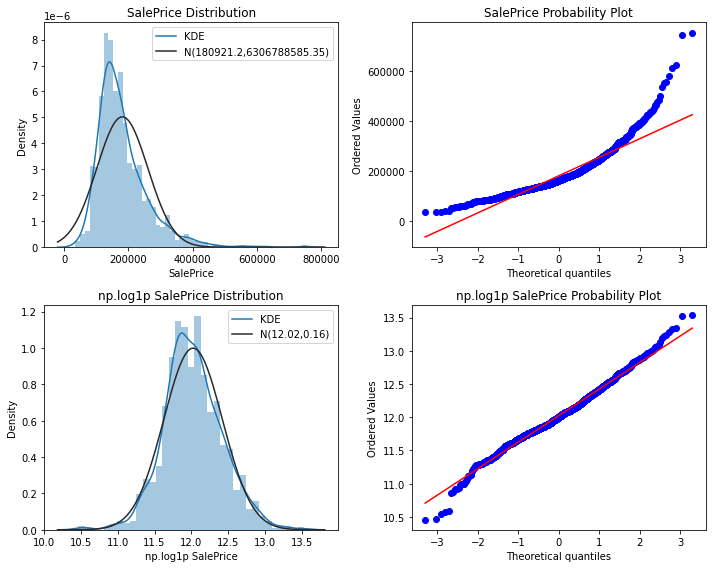

In [52]:
QQ_plot(df_eda['SalePrice'], 'SalePrice', True)

(1460, 99) (1455, 99)
(1460, 99) (1458, 99)
(1460, 99) (1453, 99)


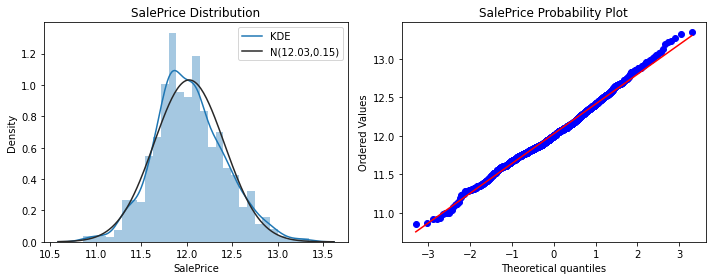

In [53]:
cond1 = (np.log1p(df_eda['SalePrice']) >= 10.7)
cond2 = (np.log1p(df_eda['SalePrice']) <  13.5)
df_eda_new = df_eda.loc[cond1]
print(df_eda.shape, df_eda_new.shape)
df_eda_new = df_eda.loc[cond2]
print(df_eda.shape, df_eda_new.shape)
df_eda_new = df_eda.loc[cond1 & cond2]
print(df_eda.shape, df_eda_new.shape)
QQ_plot(np.log1p(df_eda_new['SalePrice']), 'SalePrice', False)

(1460, 99) (1455, 99)
(1460, 99) (1456, 99)
(1460, 99) (1451, 99)


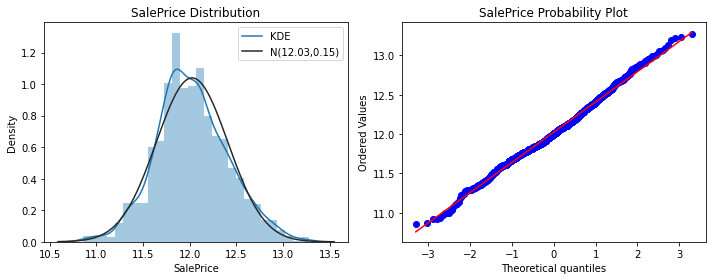

In [54]:
cond1 = (np.log1p(df_eda['SalePrice']) >= 10.7)
cond2 = (np.log1p(df_eda['SalePrice']) <  13.3)
df_eda_new = df_eda.loc[cond1]
print(df_eda.shape, df_eda_new.shape)
df_eda_new = df_eda.loc[cond2]
print(df_eda.shape, df_eda_new.shape)
df_eda_new = df_eda.loc[cond1 & cond2]
print(df_eda.shape, df_eda_new.shape)
QQ_plot(np.log1p(df_eda_new['SalePrice']), 'SalePrice', False)

## 3.3. Features와 Target 값 상관관계 분석

In [55]:
print(f'col_nona_numerical : {col_nona_numerical}')
print(f'col_nona_numerical_predict : {col_nona_numerical_predict}')
print(f'col_hasna_numerical : {col_hasna_numerical}')
print(f'col_hasna_numerical_predict : {col_hasna_numerical_predict}')
print(f'col_nona_object : {col_nona_object}')
print(f'col_nona_object_predict : {col_nona_object_predict}')
print(f'col_hasna_object : {col_hasna_object}')
print(f'col_hasna_object_predict : {col_hasna_object_predict}')
print(f'col_gen_flagfields : {col_gen_flagfields}')
print(f'col_gen_datefields : {col_gen_datefields}')
# except train features
dropfeatures = ['SalePrice','Id']
print(f'train data need to drop Features : {dropfeatures}')

col_nona_numerical : ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
col_nona_numerical_predict : ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
col_hasna_numerical : ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
col_hasna_numerical_predict : ['LotFrontage', 'MasVnrArea', 

In [56]:
def multiplots(col, target, data, huecol=''):
    
    # 각 행이 1개이고, 열이 5개인 서브 플롯을 생성합니다.
    fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(28,4))
    #fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(28,4))
    #sns.despine(left=True)
    
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정합니다. 
    fig.subplots_adjust(hspace=.4, wspace=.1)

    #countplot, barplot, histogram, pointplot
    #scatter, regplot, boxplot

    charts = [
              {'Index' : 0, 'ChartName' : 'LinePlot'   , 'Chart' : 'sns.lineplot'    , 'Param' : 'x,y,d'},
              {'Index' : 1, 'ChartName' : 'PointPlot'  , 'Chart' : 'sns.pointplot'   , 'Param' : 'x,y,d'},
              {'Index' : 2, 'ChartName' : 'ScatterPlot', 'Chart' : 'sns.scatterplot' , 'Param' : 'x,y,d'},
#               {'Index' : 2, 'ChartName' : 'ViolinPlot' , 'Chart' : 'sns.violinplot'  , 'Param' : 'x,y,d'},
              {'Index' : 3, 'ChartName' : 'RegPlot'    , 'Chart' : 'sns.regplot'     , 'Param' : 'x,y,d'},
              {'Index' : 4, 'ChartName' : 'BoxPlot'    , 'Chart' : 'sns.boxplot'     , 'Param' : 'x,y,d'},
             ]
    for idx, ax in enumerate(axes.flatten()):
        isvisible = False
        for chart in charts:
            if idx == chart['Index']:
                # print(idx, chart["ChartName"], chart['Param'], ax)
                func = eval(chart['Chart'])
                if chart['Param'] == 'x,y,d':
                    func(x=col, y=target, data=data, ax=ax)
                elif chart['Param'] == 'x,y,h,d':
                    func(x=col, y=target, hue=huecol, data=data, ax=ax)
                elif chart['Param'] == 'y,x,d':
                    func(y=col, x=target, data=data, ax=ax)
                elif chart['Param'] == 'y,x,h,d':
                    func(y=col, x=target, hue=huecol, data=data, ax=ax)
                ax.set_title(f'{col} - {chart["ChartName"]}')
                ax.set_xlabel('')
                ax.set_ylabel('')
                isvisible = True
        ax.set_visible(True if isvisible else False)

    plt.tight_layout() # 서브 플롯 layout 조정

    # 각 행이 1개이고, 열이 5개인 서브 플롯을 생성합니다.
#     fig2, axes2 = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(28,4))
    fig2, axes2 = plt.subplots(nrows=1, ncols=5, figsize=(28,4))
    #sns.despine(left=True)
    
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정합니다. 
    fig2.subplots_adjust(hspace=.4, wspace=.1)
    
#     print(axes2)
# #     sns.displot(data=data, x=col, kind='kde', ax=axes2[0])
# #     sns.displot(data=data, x=col, kde=True, ax=axes2[1])
#     sns.kdeplot(data=data, x=col, ax=axes2[0])
#     sns.distplot(data[col],ax=axes2[1])
#     sns.histplot(data=data, x=col, ax=axes2[2])
# #     sns.histplot(data=data, x=col, ax=axes2[1])

    charts2 = [
              {'Index' : 0, 'ChartName' : 'KdePlot'     , 'Chart' : 'sns.kdeplot'     , 'Param' : 'd,x'},
              {'Index' : 1, 'ChartName' : 'DistPlot'    , 'Chart' : 'sns.distplot'    , 'Param' : 'dc'},
              {'Index' : 2, 'ChartName' : 'HistPlot'    , 'Chart' : 'sns.histplot'    , 'Param' : 'd,x'},
             ]
    for idx, ax in enumerate(axes2.flatten()):
        isvisible = False
        for chart in charts2:
            if idx == chart['Index']:
                # print(idx, chart["ChartName"], chart['Param'], ax)
                func = eval(chart['Chart'])
                if chart['Param'] == 'dc':
                    func(data[col], ax=ax)
                elif chart['Param'] == 'd,x':
                    func(data=data, x=col, ax=ax)
                elif chart['Param'] == 'd,x,h':
                    func(data=data, x=col, hue=huecol, ax=ax)
                ax.set_title(f'{col} - {chart["ChartName"]}')
                ax.set_xlabel('')
                ax.set_ylabel('')
                isvisible = True
        ax.set_visible(True if isvisible else False)

    plt.tight_layout()  # 서브 플롯 layout 조정
    plt.show()

In [57]:
# Search Columns
searchcols = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields
for dropfeature in dropfeatures:
    searchcols.remove(dropfeature)

In [58]:
# Draw Chart
for idx, feature in enumerate(searchcols):
    print(f'.... index : {idx} ... col : [{feature}] huecol : []')
#     multiplots(feature, 'SalePrice', df_eda, '')

.... index : 0 ... col : [MSSubClass] huecol : []
.... index : 1 ... col : [LotArea] huecol : []
.... index : 2 ... col : [OverallQual] huecol : []
.... index : 3 ... col : [OverallCond] huecol : []
.... index : 4 ... col : [YearBuilt] huecol : []
.... index : 5 ... col : [YearRemodAdd] huecol : []
.... index : 6 ... col : [BsmtFinSF1] huecol : []
.... index : 7 ... col : [BsmtFinSF2] huecol : []
.... index : 8 ... col : [BsmtUnfSF] huecol : []
.... index : 9 ... col : [TotalBsmtSF] huecol : []
.... index : 10 ... col : [1stFlrSF] huecol : []
.... index : 11 ... col : [2ndFlrSF] huecol : []
.... index : 12 ... col : [LowQualFinSF] huecol : []
.... index : 13 ... col : [GrLivArea] huecol : []
.... index : 14 ... col : [BsmtFullBath] huecol : []
.... index : 15 ... col : [BsmtHalfBath] huecol : []
.... index : 16 ... col : [FullBath] huecol : []
.... index : 17 ... col : [HalfBath] huecol : []
.... index : 18 ... col : [BedroomAbvGr] huecol : []
.... index : 19 ... col : [KitchenAbvGr] h

## 3.4. Feature간 correlation 높은 것 그룹핑

In [59]:
def df_fcorr(df, corr_value = 0.9):
    ''' Numerical Features간 correlation이 있는 필드 정보 리스트 추출
    '''
    df_corr = df.corr()
    indexes = df_corr.index

    corr_features_list = []
    for idx in range(0, math.ceil(len(indexes)/2)):
        if indexes[idx] == 'Id' :
            continue
#         print(f'index : {idx} = {indexes[idx]}')
        high_corr = corr_value
        cond1 = df_corr[indexes[idx]] < 1
        cond2 = df_corr[indexes[idx]] >= high_corr
        if df_corr[(cond1) & (cond2)].shape[0] > 0 :
            corr_features = set(df_corr[(cond1) & (cond2)].index)
            corr_features.add(indexes[idx])
#             print(corr_features)
            if not corr_features in corr_features_list :
                corr_features_list.append(corr_features)
    return corr_features_list
corr_features = df_fcorr(df_eda, 0.8)
print(corr_features)

[{'gen_existflag_Alley', 'Alley'}, {'YearBuilt', 'gen_grpdate_YearBuilt'}, {'gen_grpdate_YearRemodAdd', 'YearRemodAdd'}, {'Exterior2nd', 'Exterior1st'}, {'TotalBsmtSF', '1stFlrSF'}, {'TotRmsAbvGrd', 'GrLivArea'}]


In [60]:
# Draw Chart
for idx, feature in enumerate(corr_features):
    print(f'.... index : {idx} ... col : [{feature}] huecol : []')
#     multiplots(list(feature)[0], list(feature)[1], df_eda, '')

.... index : 0 ... col : [{'gen_existflag_Alley', 'Alley'}] huecol : []
.... index : 1 ... col : [{'YearBuilt', 'gen_grpdate_YearBuilt'}] huecol : []
.... index : 2 ... col : [{'gen_grpdate_YearRemodAdd', 'YearRemodAdd'}] huecol : []
.... index : 3 ... col : [{'Exterior2nd', 'Exterior1st'}] huecol : []
.... index : 4 ... col : [{'TotalBsmtSF', '1stFlrSF'}] huecol : []
.... index : 5 ... col : [{'TotRmsAbvGrd', 'GrLivArea'}] huecol : []


## 3.5. Features와 Target 값 상관관계 및 Feature간 correlation 높은 것 그룹핑 분석결과

### 3.5.1 분석 제외 컬럼 목록

In [61]:
# exception feature list
col_except_feature_list = []
for idx, feature in enumerate(searchcols):
    if idx in [31,32,39,45,64,86,95]:
        print(f'exception feature : index : {idx} [{feature}]')
        col_except_feature_list.append(feature)
print(col_except_feature_list)

exception feature : index : 31 [MoSold]
exception feature : index : 32 [YrSold]
exception feature : index : 39 [LandContour]
exception feature : index : 45 [Condition2]
exception feature : index : 64 [MasVnrType]
exception feature : index : 86 [gen_existflag_Electrical]
exception feature : index : 95 [gen_grpdate_YrSold]
['MoSold', 'YrSold', 'LandContour', 'Condition2', 'MasVnrType', 'gen_existflag_Electrical', 'gen_grpdate_YrSold']


### 3.5.2 Outlier 처리 대상 컬럼 목록

In [62]:
# outlier feature list
col_need_outlier_handing_list = []
for idx, feature in enumerate(searchcols):
    if idx in [1,4,6,7,8,9,10,11,12,13,23,24,25,26,30,33,34]:
        print(f'need outlier heanding feature : index : {idx} [{feature}]')
        col_need_outlier_handing_list.append(feature)
print(col_need_outlier_handing_list)

need outlier heanding feature : index : 1 [LotArea]
need outlier heanding feature : index : 4 [YearBuilt]
need outlier heanding feature : index : 6 [BsmtFinSF1]
need outlier heanding feature : index : 7 [BsmtFinSF2]
need outlier heanding feature : index : 8 [BsmtUnfSF]
need outlier heanding feature : index : 9 [TotalBsmtSF]
need outlier heanding feature : index : 10 [1stFlrSF]
need outlier heanding feature : index : 11 [2ndFlrSF]
need outlier heanding feature : index : 12 [LowQualFinSF]
need outlier heanding feature : index : 13 [GrLivArea]
need outlier heanding feature : index : 23 [GarageArea]
need outlier heanding feature : index : 24 [WoodDeckSF]
need outlier heanding feature : index : 25 [OpenPorchSF]
need outlier heanding feature : index : 26 [EnclosedPorch]
need outlier heanding feature : index : 30 [MiscVal]
need outlier heanding feature : index : 33 [LotFrontage]
need outlier heanding feature : index : 34 [MasVnrArea]
['LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtU

In [63]:
#Outlier 처리 
col_result_outlier_list = [] # outlier 처리 결과 features
for col in col_need_outlier_handing_list: # 상관관계 분석결과 need outlier handing features
    p01 = df_eda[col].quantile(0.01) 
    p99 = df_eda[col].quantile(0.99) 

    df_eda[f'gen_outlier_{col}']   = df_eda[col].clip(p01, p99) # assign Train quantile value
    col_result_outlier_list.append(f'gen_outlier_{col}')

In [64]:
def compare_multiplots(befcol, aftcol, target, data, huecol='') :
    
    # 각 행이 1개이고, 열이 6개인 서브 플롯을 생성합니다.
#     fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(28,4))
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(28,4))
    
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정합니다. 
    fig.subplots_adjust(hspace=.4, wspace=.1)

    charts = [
              {'Index' : 0, 'ChartName' : 'LinePlot'   , 'Chart' : 'sns.lineplot'    , 'Param' : 'bx,y,d'},
              {'Index' : 1, 'ChartName' : 'LinePlot'   , 'Chart' : 'sns.lineplot'    , 'Param' : 'ax,y,d'},
              {'Index' : 2, 'ChartName' : 'RegPlot'    , 'Chart' : 'sns.regplot'     , 'Param' : 'bx,y,d'},
              {'Index' : 3, 'ChartName' : 'RegPlot'    , 'Chart' : 'sns.regplot'     , 'Param' : 'ax,y,d'},
              {'Index' : 4, 'ChartName' : 'DistPlot'   , 'Chart' : 'sns.distplot'    , 'Param' : 'dbc'},
              {'Index' : 5, 'ChartName' : 'DistPlot'   , 'Chart' : 'sns.distplot'    , 'Param' : 'dac'},
             ]
    for idx, ax in enumerate(axes.flatten()):
        isvisible = False
        for chart in charts:
            if idx == chart['Index']:
                # print(idx, chart["ChartName"], chart['Param'], ax)
                func = eval(chart['Chart'])
                if chart['Param'] == 'bx,y,d':
                    func(x=befcol, y=target, data=data, ax=ax)
                    ax.set_title(f'{befcol} - {chart["ChartName"]}')
                elif chart['Param'] == 'bx,y,h,d':
                    func(x=befcol, y=target, hue=huecol, data=data, ax=ax)
                    ax.set_title(f'{befcol} - {chart["ChartName"]}')
                elif chart['Param'] == 'ax,y,d':
                    func(x=aftcol, y=target, data=data, ax=ax)
                    ax.set_title(f'{aftcol} - {chart["ChartName"]}')
                elif chart['Param'] == 'ax,y,h,d':
                    func(x=aftcol, y=target, data=data, ax=ax)
                    ax.set_title(f'{aftcol} - {chart["ChartName"]}')
                elif chart['Param'] == 'dbc':
                    func(data[befcol], ax=ax)
                    ax.set_title(f'{befcol} - {chart["ChartName"]}')
                elif chart['Param'] == 'dac':
                    func(data[aftcol], ax=ax)
                    ax.set_title(f'{aftcol} - {chart["ChartName"]}')
                ax.set_xlabel('')
                ax.set_ylabel('')
                isvisible = True
        ax.set_visible(True if isvisible else False)

    plt.tight_layout() # 서브 플롯 layout 조정
    plt.show()

In [65]:
# Outlier 처리 후 Draw Chart
for idx in range(0, len(col_need_outlier_handing_list)):
    print(f'... idx [{idx}] ... total [{len(col_need_outlier_handing_list)}]')
#     compare_multiplots(col_need_outlier_handing_list[idx], col_result_outlier_list[idx], 'SalePrice', df_eda, '')

... idx [0] ... total [17]
... idx [1] ... total [17]
... idx [2] ... total [17]
... idx [3] ... total [17]
... idx [4] ... total [17]
... idx [5] ... total [17]
... idx [6] ... total [17]
... idx [7] ... total [17]
... idx [8] ... total [17]
... idx [9] ... total [17]
... idx [10] ... total [17]
... idx [11] ... total [17]
... idx [12] ... total [17]
... idx [13] ... total [17]
... idx [14] ... total [17]
... idx [15] ... total [17]
... idx [16] ... total [17]


### 3.5.3 correlation 높은 그룹 선별 목록

In [66]:
# correlation high feature list
col_corr_high_list = []
for idx, feature in enumerate(corr_features):
    if idx in [3,4,5]:
        print(f'correlation high feature : index : {idx} [{feature}]')
        col_corr_high_list.append(feature)
print(col_corr_high_list)
print(corr_features)

correlation high feature : index : 3 [{'Exterior2nd', 'Exterior1st'}]
correlation high feature : index : 4 [{'TotalBsmtSF', '1stFlrSF'}]
correlation high feature : index : 5 [{'TotRmsAbvGrd', 'GrLivArea'}]
[{'Exterior2nd', 'Exterior1st'}, {'TotalBsmtSF', '1stFlrSF'}, {'TotRmsAbvGrd', 'GrLivArea'}]
[{'gen_existflag_Alley', 'Alley'}, {'YearBuilt', 'gen_grpdate_YearBuilt'}, {'gen_grpdate_YearRemodAdd', 'YearRemodAdd'}, {'Exterior2nd', 'Exterior1st'}, {'TotalBsmtSF', '1stFlrSF'}, {'TotRmsAbvGrd', 'GrLivArea'}]


## 3-77 df_eda 제거하기

In [67]:
del df_eda

# 4. 데이터 전처리(Data Preprecessing)

## 4.1 전처리용 데이터 준비하기

In [68]:
# 모델 성능 그래프 Label 정보 활용 
trynum = 0

In [69]:
# 그래프 초기화
utils.clear_error()


In [70]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_prep_train = train.copy()
df_prep_predict = test.copy()

In [71]:
# 작업 명세서 초기화
change_work = ''

## 4.2 예측값 지수함수처리

In [72]:
print(df_prep_train['SalePrice'].shape, df_prep_train['SalePrice'].head())
df_prep_train['SalePrice'] = df_prep_train['SalePrice'].apply(lambda x : np.log1p(x))
cond1 = (df_prep_train['SalePrice'] >= 10.7)
cond2 = (df_prep_train['SalePrice'] <  13.5)
df_prep_train = df_prep_train.loc[cond1 & cond2]
print(df_prep_train['SalePrice'].shape, df_prep_train['SalePrice'].head())
change_work += 'Filter 10.7 <= SalePrice <13.5,'
# change_work += 'SalePrice Filter 10.7<= .. <13.3 '
# change_work += 'SalePrice NoFilter '

(1460,) 0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64
(1453,) 0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64


## 4.3 결측치 보정 전 신규 Feature 생성

#### 1) Train Data 처리

In [73]:
change_work += 'add flag field in train,'
# flag field 추가
add_flagfields(df_prep_train)
# 추가 flag field 변수
col_gen_flagfields = list(df_prep_train.filter(regex='gen_existflag_').columns)
df_prep_train[col_gen_flagfields].describe()

gen_existflag_Alley
gen_existflag_MasVnrType
gen_existflag_BsmtQual
gen_existflag_BsmtCond
gen_existflag_BsmtExposure
gen_existflag_BsmtFinType1
gen_existflag_BsmtFinType2
gen_existflag_Electrical
gen_existflag_FireplaceQu
gen_existflag_GarageType
gen_existflag_PoolQC
gen_existflag_Fence
gen_existflag_MiscFeature


,gen_existflag_Alley,gen_existflag_MasVnrType,gen_existflag_BsmtQual,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,0.061941,0.994494,0.975224,0.975224,0.974535,0.975224,0.974535,0.999312,0.528562,0.946318,0.004129,0.190640,0.037164
std,0.241131,0.074022,0.155496,0.155496,0.157586,0.155496,0.157586,0.026234,0.499355,0.225467,0.064150,0.392941,0.189230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2) Predict Data 처리

In [74]:
change_work += 'add flag field in predict,'
add_flagfields(df_prep_predict)
# 추가 flag field 변수
df_prep_predict[col_gen_flagfields].describe()

gen_existflag_Alley
gen_existflag_MasVnrType
gen_existflag_BsmtQual
gen_existflag_BsmtCond
gen_existflag_BsmtExposure
gen_existflag_BsmtFinType1
gen_existflag_BsmtFinType2
gen_existflag_Electrical
gen_existflag_FireplaceQu
gen_existflag_GarageType
gen_existflag_PoolQC
gen_existflag_Fence
gen_existflag_MiscFeature


,gen_existflag_Alley,gen_existflag_MasVnrType,gen_existflag_BsmtQual,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.073338,0.989034,0.969842,0.969157,0.969842,0.971213,0.971213,1.0,0.499657,0.947910,0.002056,0.198766,0.034955
std,0.260780,0.104181,0.171080,0.172952,0.171080,0.167264,0.167264,0.0,0.500171,0.222286,0.045314,0.399209,0.183730
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


## 4.4 결측치 보정

### 4.4.1 Numerical 컬럼 결측치 처리

#### 1) Train Data 처리

In [75]:
change_work += 'numeric fillna in train,'
# numerical feature 결측치 보정하기
df_numerical_fillna(df_prep_train, 'Train')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,1,0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,1,1
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,0


#### 2) Predict Data 처리

In [76]:
change_work += 'numeric fillna in predict,'
# numerical feature 결측치 보정하기
df_numerical_fillna(df_prep_predict, 'Predict')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,1,0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,1
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,1,0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,1,1,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,0,0,0,0
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,1,0,0,0
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,1,1,0,0,0
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,1,1,1,1,1,0,0,0,1,1


### 4.4.2 Object 컬럼 결측치 처리 및 숫자형 변환 동시 처리

#### 1) Train Data 처리

In [77]:
change_work += 'object fillna and convert to num in train,'
# object feature 결측치 보정 및 숫자형 변환
df_object_fillna(df_prep_train, df_prep_predict, 'Train')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1,60,4,65.0,8450,2,0,4,4,1,...,1,1,1,1,1,0,1,0,0,0
1,2,20,4,80.0,9600,2,0,4,4,1,...,1,1,1,1,1,1,1,0,0,0
2,3,60,4,68.0,11250,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
3,4,70,4,60.0,9550,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
4,5,60,4,84.0,14260,2,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,4,62.0,7917,2,0,4,4,1,...,1,1,1,1,1,1,1,0,0,0
1456,1457,20,4,85.0,13175,2,0,4,4,1,...,1,1,1,1,1,1,1,0,1,0
1457,1458,70,4,66.0,9042,2,0,4,4,1,...,1,1,1,1,1,1,1,0,1,1
1458,1459,20,4,68.0,9717,2,0,4,4,1,...,1,1,1,1,1,0,1,0,0,0


#### 2) Predict Data 처리

In [78]:
change_work += 'object fillna and convert to num in predict,'
# object feature 결측치 보정 및 숫자형 변환
df_object_fillna(df_prep_predict, df_prep_train, 'Predict')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,gen_existflag_BsmtCond,gen_existflag_BsmtExposure,gen_existflag_BsmtFinType1,gen_existflag_BsmtFinType2,gen_existflag_Electrical,gen_existflag_FireplaceQu,gen_existflag_GarageType,gen_existflag_PoolQC,gen_existflag_Fence,gen_existflag_MiscFeature
0,1461,20,8,80.0,11622,4,0,8,8,3,...,1,1,1,1,1,0,1,0,1,0
1,1462,20,9,81.0,14267,4,0,5,8,3,...,1,1,1,1,1,0,1,0,0,1
2,1463,60,9,74.0,13830,4,0,5,8,3,...,1,1,1,1,1,1,1,0,1,0
3,1464,60,9,78.0,9978,4,0,5,8,3,...,1,1,1,1,1,1,1,0,0,0
4,1465,120,9,43.0,5005,4,0,5,6,3,...,1,1,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,10,21.0,1936,4,0,8,8,3,...,1,1,1,1,1,0,0,0,0,0
1455,2916,160,10,21.0,1894,4,0,8,8,3,...,1,1,1,1,1,0,1,0,0,0
1456,2917,20,9,160.0,20000,4,0,8,8,3,...,1,1,1,1,1,1,1,0,0,0
1457,2918,85,9,62.0,10441,4,0,8,8,3,...,1,1,1,1,1,0,0,0,1,1


## 4.5 결측치 보정 후 신규 Feature 추가

#### 1) Train Data 처리

In [79]:
change_work += 'add datefields in train,'
# 추가 date field 생성
add_datafields(df_prep_train) 
# 추가 date field 변수
col_gen_datefields = list(df_prep_train.filter(regex='gen_grpdate_').columns)
print(col_gen_datefields)

gen_grpdate_YearBuilt
gen_grpdate_YearRemodAdd
gen_grpdate_GarageYrBlt
gen_grpdate_YrSold
gen_grpdate_MoSold
['gen_grpdate_YearBuilt', 'gen_grpdate_YearRemodAdd', 'gen_grpdate_GarageYrBlt', 'gen_grpdate_YrSold', 'gen_grpdate_MoSold']


#### 2) Predict Data 처리

In [80]:
change_work += 'add datefields in predict,'
# 추가 date field 생성
add_datafields(df_prep_predict) 

gen_grpdate_YearBuilt
gen_grpdate_YearRemodAdd
gen_grpdate_GarageYrBlt
gen_grpdate_YrSold
gen_grpdate_MoSold


## 4.6 Skewed Data log function 처리

In [81]:
## result message
change_work += 'skewed data np.log1p function before outliyer process '
for col in col_union_skewed_0point5 :
    bef_data = df_prep_train[col]
    df_prep_train[col] = np.log1p(df_prep_train[col])
    df_prep_predict[col] = np.log1p(df_prep_predict[col])
#     print(f'skewed feature np.log1p : {col} - bef [{bef_data}], aft [{df_prep_train[col]}]')
    print(f'skewed feature np.log1p : {col}')

# change_work += 'skewed data boxcox1p lambda(0.15) function before outliyer process '
# lambda_select = 0.1  # 0.15
# for col in col_union_skewed_0point5 :
#     bef_data = df_prep_train[col]
#     df_prep_train[col] = boxcox1p(df_prep_train[col], lambda_select)
#     df_prep_predict[col] = boxcox1p(df_prep_predict[col], lambda_select)
# #     print(f'skewed feature boxcox1p : {col} - bef [{bef_data}], aft [{df_prep_train[col]}]')
#     print(f'skewed feature boxcox1p : {col}')

skewed feature np.log1p : LotArea
skewed feature np.log1p : 2ndFlrSF
skewed feature np.log1p : TotalBsmtSF
skewed feature np.log1p : MSSubClass
skewed feature np.log1p : EnclosedPorch
skewed feature np.log1p : BsmtFullBath
skewed feature np.log1p : BsmtFinSF2
skewed feature np.log1p : BedroomAbvGr
skewed feature np.log1p : 3SsnPorch
skewed feature np.log1p : 1stFlrSF
skewed feature np.log1p : WoodDeckSF
skewed feature np.log1p : LowQualFinSF
skewed feature np.log1p : BsmtUnfSF
skewed feature np.log1p : TotRmsAbvGrd
skewed feature np.log1p : OverallCond
skewed feature np.log1p : GrLivArea
skewed feature np.log1p : GarageYrBlt
skewed feature np.log1p : Fireplaces
skewed feature np.log1p : BsmtHalfBath
skewed feature np.log1p : MasVnrArea
skewed feature np.log1p : ScreenPorch
skewed feature np.log1p : YearRemodAdd
skewed feature np.log1p : OpenPorchSF
skewed feature np.log1p : BsmtFinSF1
skewed feature np.log1p : PoolArea
skewed feature np.log1p : LotFrontage
skewed feature np.log1p : Yea

## 4.7 Outlier 

#### 1) Train Data 처리

In [82]:
#Outlier flag 설정  
# def outlier(x, p01, p99):
#   if x < p01 or x > p99:
#     return 'Y'
#   else:
#     return 'N'
# for col in col_need_outlier_handing_list: # 상관관계 분석결과 need outlier handing features
#     p01 = df_prep_train[col].quantile(0.01) 
#     p99 = df_prep_train[col].quantile(0.99) 

#     df_prep_train[f'gen_outlier_flag_{col}'] = df_prep_train[col].apply(outlier, args=(p01, p99))  # check info

In [83]:
change_work += 'outlier in train,'
#Outlier 처리 
for col in col_need_outlier_handing_list: # 상관관계 분석결과 need outlier handing features
    p01 = df_prep_train[col].quantile(0.01) 
    p99 = df_prep_train[col].quantile(0.99) 

    df_prep_train[f'gen_outlier_{col}']   = df_prep_train[col].clip(p01, p99) # assign Train quantile value

#### 2) Predict Data 처리

In [84]:
change_work += 'outlier in predict,'
#Outlier 처리 
for col in col_need_outlier_handing_list: # 상관관계 분석결과 need outlier handing features
    p01 = df_prep_train[col].quantile(0.01) # Train quantile value
    p99 = df_prep_train[col].quantile(0.99) # Train quantile value

    df_prep_predict[f'gen_outlier_{col}'] = df_prep_predict[col].clip(p01, p99) # assign Train quantile value
#     print(f'p01 : {p01}, p99: {p99}')
#     display(df_prep_predict[col].clip(p01, p99))

## 4.8 데이타 표준화 처리

In [85]:
scaler = StandardScaler()

In [86]:
# print(f'col_nona_numerical : {col_nona_numerical}')
# print(f'col_nona_numerical_predict : {col_nona_numerical_predict}')
# print(f'col_hasna_numerical : {col_hasna_numerical}')
# print(f'col_hasna_numerical_predict : {col_hasna_numerical_predict}')
# print(f'col_nona_object : {col_nona_object}')
# print(f'col_nona_object_predict : {col_nona_object_predict}')
# print(f'col_hasna_object : {col_hasna_object}')
# print(f'col_hasna_object_predict : {col_hasna_object_predict}')
# print(f'col_gen_flagfields : {col_gen_flagfields}')
# print(f'col_gen_datefields : {col_gen_datefields}')
# print(f'col_except_feature_list : {col_except_feature_list}')
# print(f'col_need_outlier_handing_list : {col_need_outlier_handing_list}')
# print(f'col_result_outlier_list : {col_result_outlier_list}')

# dropfeatures = ['SalePrice','Id']
# print(f'train data need to drop Features : {dropfeatures}')
# 학습 데이터 각 변수의 평균값과 표준편차를 저장한 후, 이를 사용하여 학습 및 평가용 데이터를 변환
apply_column = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_datefields \
               + col_result_outlier_list  # outlier generate feature 추가
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in dropfeatures:
        apply_column.remove(dropfeature)
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in apply_column:
        apply_column.remove(exceptfeature)
for outlier in col_need_outlier_handing_list: # need outlier handing feature 제외
    if outlier in apply_column:
        apply_column.remove(outlier)
change_work += 'stadardscaler in train,'
# Train data standardscale
df_prep_train[apply_column] = scaler.fit_transform(df_prep_train[apply_column])
change_work += 'stadardscaler in predict,'
# Predict data standardscale
df_prep_predict[apply_column] = scaler.fit_transform(df_prep_predict[apply_column])

In [87]:
sp.mean(df_prep_train[apply_column], axis=0).head(3).round(3), sp.std(df_prep_predict[apply_column], axis=0).head(3).round(3)

(MSSubClass    -0.0
 OverallQual    0.0
 OverallCond    0.0
 dtype: float64,
 MSSubClass     1.0
 OverallQual    1.0
 OverallCond    1.0
 dtype: float64)

### 4.8.1 표준화 처리 데이터와 'SalePrice' 상관관계가 높은 컬럼만 선별하기

In [88]:
details = rstr(df_prep_train, 'SalePrice')
cond1 = details['corr SalePrice'] >= 0.1
cond2 = details['corr SalePrice'] <= -0.1
details_corr = details[(cond1) | (cond2)]
details_corr = details                ## Ridge도 전체 컬럼으로 분석하는 것이 성능 좋음으로 모든 컬럼으로 적용함.
select_cols = set(details_corr.index)
print(select_cols, len(select_cols))

Data shape: (1453, 116)
___________________________
Data types:
 float64    95
int64      21
Name: types, dtype: int64
___________________________
{'gen_existflag_FireplaceQu', 'SaleType', 'gen_outlier_TotalBsmtSF', 'gen_existflag_BsmtQual', 'MSSubClass', 'KitchenQual', 'OverallQual', 'ExterCond', 'gen_existflag_BsmtExposure', 'Neighborhood', 'gen_outlier_LowQualFinSF', 'BsmtFinType2', 'GarageQual', 'BldgType', 'SalePrice', 'ExterQual', 'BsmtCond', 'BsmtUnfSF', 'gen_grpdate_YrSold', 'PavedDrive', 'TotRmsAbvGrd', 'GrLivArea', 'GarageArea', 'Fireplaces', 'RoofStyle', 'YearRemodAdd', 'gen_outlier_GarageArea', 'Street', 'GarageType', 'Condition1', 'gen_grpdate_YearBuilt', 'LotShape', 'gen_outlier_LotFrontage', 'Alley', 'MiscVal', 'BsmtQual', 'KitchenAbvGr', 'LotArea', 'YrSold', '2ndFlrSF', 'gen_existflag_Fence', 'TotalBsmtSF', 'LandSlope', 'Exterior1st', 'HeatingQC', 'LotConfig', 'gen_existflag_BsmtFinType2', 'gen_outlier_MasVnrArea', 'Exterior2nd', 'gen_existflag_GarageType', 'FullBath', 

In [89]:
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in select_cols :
        select_cols.remove(exceptfeature)
for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결과 리스트를 추가하기
    if outlierfeature in select_cols :
        select_cols.remove(outlierfeature)
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in select_cols :
        select_cols.remove(dropfeature)

In [90]:
# Feature간 유사도가 높은 컬럼들은 1개만 select_cols에 포함되도록 처리
for items in col_corr_high_list:
    is_exist = False
    for item in list(items):
        if item in select_cols :
            if is_exist == False :
                is_exist = True
            else :
                select_cols.remove(item)

len(select_cols)

89

In [91]:
# result message
# change_work += '유사컬럼은 1개만 선택,''
# change_work += '컬럼선별:corr >= |0.1|,'

# 5. 모델링(Modeling)

## 5.1 모델 성능 평가함수 정의

In [92]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
  return round(mean_squared_error(y_true, y_pred, squared=False), 4)

## 5.2 모델 공통 정보 설정

In [93]:
MODEL_SEED = 123

In [94]:
TEST_SIZE = 0.15
# result message
change_work += 'SEED=123,TEST_SIZE=0.15,'
# change_work += 'SEED=123,TEST_SIZE=0.1,'

## 5.3 모델구축

### 5.4.1 Ridge 회귀모델

#### 5.4.1.1 데이타 분할

In [95]:
# result message
# change_work += 'Ridge : 컬럼선별:corr >= |0.5|,'
# change_work += 'Ridge : ALL,'
change_work += 'Ridge : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
        + col_result_outlier_list # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in col_X :
        col_X.remove(exceptfeature)
for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
    if outlierfeature in col_X :
        col_X.remove(outlierfeature)
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in col_X :
        col_X.remove(dropfeature)
# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
# col_X = list(select_cols)
col_y = 'SalePrice'

print(col_X)
print(f'Ridge Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_ridge_train_raw = df_prep_train[col_X]
y_ridge_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_ridge_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_ridge_train, x_ridge_valid, y_ridge_train, y_ridge_valid = train_test_split(x_ridge_train_raw, y_ridge_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'GarageYrBlt', 'MSZoning', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'gen_existflag_Alley', 'gen_existflag_MasVnrType', 'gen_existflag_BsmtQual', 'gen_existflag_BsmtCond', 'gen_existflag_BsmtExposure', 'gen_existflag_BsmtFinType1', 'gen_existflag_BsmtFinType2', 'gen_existflag_Fireplac

#### 5.4.1.2 Ridge 회귀모델

In [96]:
%%time

# change_work += 'ridge  range(170, 210, 5)'
change_work += ' ridge np.logspace(-2,1,10)'

# log 단위(1e+01)로 1.e-02 ~ 1.e+01 구간에 대해 매개변수를 탐색합니다.
ridge_params = {
    'alpha': np.logspace(-2,1,10),
#     'alpha': range(170, 210, 5),
    'random_state' : [MODEL_SEED]
}


CPU times: user 526 µs, sys: 51 µs, total: 577 µs
Wall time: 587 µs


In [97]:
%%time

# GridSearchCV를 이용하여 Ridge 모델을 저장합니다.
ridge_model = GridSearchCV(Ridge(), param_grid=ridge_params, refit=True, scoring='neg_root_mean_squared_error')
ridge_model.fit(x_ridge_train, y_ridge_train)

CPU times: user 1.09 s, sys: 678 ms, total: 1.77 s
Wall time: 891 ms


GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'random_state': [123]},
             scoring='neg_root_mean_squared_error')

In [98]:
col_cv_results = ['params', 'mean_test_score', 'rank_test_score']
pd.DataFrame(ridge_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'alpha': 0.01, 'random_state': 123}",-0.141365,9
1,"{'alpha': 0.021544346900318832, 'random_state': 123}",-0.141391,10
2,"{'alpha': 0.046415888336127774, 'random_state': 123}",-0.141362,8
3,"{'alpha': 0.1, 'random_state': 123}",-0.141249,7
4,"{'alpha': 0.21544346900318834, 'random_state': 123}",-0.141014,6
5,"{'alpha': 0.46415888336127775, 'random_state': 123}",-0.140608,5
6,"{'alpha': 1.0, 'random_state': 123}",-0.139968,4
7,"{'alpha': 2.154434690031882, 'random_state': 123}",-0.139001,3
8,"{'alpha': 4.6415888336127775, 'random_state': 123}",-0.137658,2
9,"{'alpha': 10.0, 'random_state': 123}",-0.136133,1


In [99]:
# pd.DataFrame(ridge_model.cv_results_)

In [100]:
print(ridge_model.best_params_)

{'alpha': 10.0, 'random_state': 123}


### 5.4.2 Random Forest 모델

#### 5.4.2.1 데이타 분할

In [101]:
# result message
# change_work += 'Rf : All,'
# change_work += 'Rf : outlierfeature remove, '
change_work += 'Rf : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
        + col_result_outlier_list # outlier 처리 결과 리스트를 추가하기
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in col_X :
        col_X.remove(exceptfeature)
for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
    if outlierfeature in col_X :
        col_X.remove(outlierfeature)
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in col_X :
        col_X.remove(dropfeature)
col_y = 'SalePrice'

print(col_X)
print(f'RF Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_rf_train_raw = df_prep_train[col_X]
y_rf_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_rf_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_rf_train, x_rf_valid, y_rf_train, y_rf_valid = train_test_split(x_rf_train_raw, y_rf_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'GarageYrBlt', 'MSZoning', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'gen_existflag_Alley', 'gen_existflag_MasVnrType', 'gen_existflag_BsmtQual', 'gen_existflag_BsmtCond', 'gen_existflag_BsmtExposure', 'gen_existflag_BsmtFinType1', 'gen_existflag_BsmtFinType2', 'gen_existflag_Fireplac

#### 5.4.2.2 Random Forest 모델

In [102]:
%%time

change_work += 'Rf : param : [1300],[8] '

rf_params = {'n_estimators': [1300],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'max_features' : [8],
             'random_state' : [MODEL_SEED]
} 

# GridSearchCV를 이용하여 Randomforest 모델을 저장합니다.
rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_root_mean_squared_error')
rf_model.fit(x_rf_train, y_rf_train)

CPU times: user 22.3 s, sys: 253 ms, total: 22.5 s
Wall time: 22.6 s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [8], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [1300],
                         'random_state': [123]},
             scoring='neg_root_mean_squared_error')

In [103]:
pd.DataFrame(rf_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300, 'random_state': 123}",-0.137127,1


In [104]:
# pd.DataFrame(rf_model.cv_results_)

In [105]:
rf_model.best_params_

{'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1300,
 'random_state': 123}

### 5.4.3 XGBoost 모델

#### 5.4.3.1 데이타 분할

In [106]:
# result message
# change_work += 'XGB : All,'
# change_work += 'XGB : outlierfeature remove, '
change_work += 'XGB : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
        + col_result_outlier_list # outlier 처리 결과 리스트를 추가하기
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in col_X :
        col_X.remove(exceptfeature)
for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
    if outlierfeature in col_X :
        col_X.remove(outlierfeature)
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in col_X :
        col_X.remove(dropfeature)
col_y = 'SalePrice'


print(col_X)
print(f'XGB Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_xgb_train_raw = df_prep_train[col_X]
y_xgb_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_xgb_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_xgb_train, x_xgb_valid, y_xgb_train, y_xgb_valid = train_test_split(x_xgb_train_raw, y_xgb_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'GarageYrBlt', 'MSZoning', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'gen_existflag_Alley', 'gen_existflag_MasVnrType', 'gen_existflag_BsmtQual', 'gen_existflag_BsmtCond', 'gen_existflag_BsmtExposure', 'gen_existflag_BsmtFinType1', 'gen_existflag_BsmtFinType2', 'gen_existflag_Fireplac

#### 5.4.3.2 XGBoost 모델

In [107]:
# change_work += 'XGB : param : [400, 410],[0.05,0.1]  '
# change_work += 'XGB : param : [348, 349, 350],[0.1]  ' 
change_work += 'XGB : param : [350, 360, 370],[0.1]  ' 

# XGBoost 모델
xgb_params = {
    'n_estimators': [350, 360, 370],  # 100 1000, 500
    'learning_rate' : [0.1], # default : 0.3 (0-1)
    'eval_metric': ['rmse'],
 #   'max_depth' : [4, 6, 8, 9], # default : 6
    'objective': ['reg:squarederror'] ,
    'random_state' : [MODEL_SEED]
} 

In [108]:
%%time

# GridSearchCV를 이용하여 XGBoost 모델을 저장합니다.
xgb_model = GridSearchCV(XGBRegressor(), param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error')
xgb_model.fit(x_xgb_train, y_xgb_train)

CPU times: user 54 s, sys: 943 ms, total: 55 s
Wall time: 29.8 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [109]:
pd.DataFrame(xgb_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 350, 'objective': 'reg:squarederror', 'random_state': 123}",-0.123848,1
1,"{'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 360, 'objective': 'reg:squarederror', 'random_state': 123}",-0.123864,3
2,"{'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 370, 'objective': 'reg:squarederror', 'random_state': 123}",-0.123848,2


In [110]:
# pd.DataFrame(xgb_model.cv_results_)

In [111]:
xgb_model.best_params_

{'eval_metric': 'rmse',
 'learning_rate': 0.1,
 'n_estimators': 350,
 'objective': 'reg:squarederror',
 'random_state': 123}

### 5.4.4 Stack 모델

#### 5.4.4.1 데이타 분할

In [112]:
# result message
# change_work += 'Stack : All,'
# change_work += 'Stack : outlierfeature remove, '
change_work += 'Stack : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
        + col_result_outlier_list # outlier 처리 결과 리스트를 추가하기
for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
    if exceptfeature in col_X :
        col_X.remove(exceptfeature)
for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
    if outlierfeature in col_X :
        col_X.remove(outlierfeature)
for dropfeature in dropfeatures: #  index와 predict feature 제외
    if dropfeature in col_X :
        col_X.remove(dropfeature)
col_y = 'SalePrice'


print(col_X)
print(f'Stack Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_stack_train_raw = df_prep_train[col_X]
y_stack_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_stack_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_stack_train, x_stack_valid, y_stack_train, y_stack_valid = train_test_split(x_stack_train_raw, y_stack_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'GarageYrBlt', 'MSZoning', 'Street', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'gen_existflag_Alley', 'gen_existflag_MasVnrType', 'gen_existflag_BsmtQual', 'gen_existflag_BsmtCond', 'gen_existflag_BsmtExposure', 'gen_existflag_BsmtFinType1', 'gen_existflag_BsmtFinType2', 'gen_existflag_Fireplac

#### 5.4.4.2 stack 모델

In [113]:
%%time

# Stack up all the models above, optimized using xgboost
stack = StackingCVRegressor(regressors=(xgb_model, ridge_model, rf_model),
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)
stack.fit(np.array(x_stack_train), np.array(y_stack_train))

CPU times: user 7min 19s, sys: 8.1 s, total: 7min 27s
Wall time: 4min 49s


StackingCVRegressor(meta_regressor=GridSearchCV(cv=5,
                                                estimator=XGBRegressor(base_score=None,
                                                                       booster=None,
                                                                       callbacks=None,
                                                                       colsample_bylevel=None,
                                                                       colsample_bynode=None,
                                                                       colsample_bytree=None,
                                                                       early_stopping_rounds=None,
                                                                       enable_categorical=False,
                                                                       eval_metric=None,
                                                                       gamma=None,
                                   

### 5.5 최종모델 구축

In [114]:
# 최적의 하이퍼파라미터로 학습된 릿지 회귀 모델을 저장합니다. 
best_ridge = ridge_model.best_estimator_

# 최적의 하이퍼파라미터로 학습된 랜덤포레스트 모델을 저장합니다. 
best_rf = rf_model.best_estimator_

# 최적의 하이퍼파라미터로 학습된 XGBoost 모델을 저장합니다.  
best_xgb = xgb_model.best_estimator_

# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_ridge = best_ridge.predict(x_ridge_train)
y_pred_tr_rf = best_rf.predict(x_rf_train)
y_pred_tr_xgb = best_xgb.predict(x_xgb_train)

# 검증용 데이터셋의 타깃 변수 예측 
y_pred_va_ridge = best_ridge.predict(x_ridge_valid)
y_pred_va_rf = best_rf.predict(x_rf_valid)
y_pred_va_xgb = best_xgb.predict(x_xgb_valid)

# 평가용 데이터셋의 타깃 변수 예측 
y_pred_te_ridge = best_ridge.predict(x_ridge_predict)
y_pred_te_rf = best_rf.predict(x_rf_predict)
y_pred_te_xgb = best_xgb.predict(x_xgb_predict)

# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
y_pred_tr_en1= np.mean([y_pred_tr_ridge, y_pred_tr_xgb], axis=0)
y_pred_va_en1= np.mean([y_pred_va_ridge, y_pred_va_xgb], axis=0)
y_pred_te_en1= np.mean([y_pred_te_ridge, y_pred_te_xgb], axis=0)
# y_pred_tr_en1= np.mean([y_pred_tr_ridge, y_pred_tr_rf], axis=0)
# y_pred_va_en1= np.mean([y_pred_va_ridge, y_pred_va_rf], axis=0)
# y_pred_te_en1= np.mean([y_pred_te_ridge, y_pred_te_rf], axis=0)

print(f'en  : y_pred_tr_ridge, y_pred_tr_xgb')
print(f'en1 : y_pred_tr_ridge, y_pred_tr_rf')

# ensenble 모델 처리 함수  : 0.5, 0.1, 0.4  => 0.12762
# def combined_models(rx, rfx, xgbx):
#     return ((0.5 * best_ridge.predict(rx)) + 
#             (0.0 * best_rf.predict(rfx)) + 
#             (0.5 * best_xgb.predict(xgbx)) 
#            )
# y_pred_tr_en= combined_models(x_ridge_train  , x_rf_train  , x_xgb_train)
# y_pred_va_en= combined_models(x_ridge_valid  , x_rf_valid  , x_xgb_valid)
# y_pred_te_en= combined_models(x_ridge_predict, x_rf_predict, x_xgb_predict)

def combined_models(rx, rfx, xgbx, stackx):
    return ((0.40 * best_ridge.predict(rx)) + 
            (0.05 * best_rf.predict(rfx)) + 
            (0.05 * best_xgb.predict(xgbx)) +
            (0.50 * stack.predict(np.array(stackx)))
           )
y_pred_tr_en= combined_models(x_ridge_train  , x_rf_train  , x_xgb_train, x_stack_train)
y_pred_va_en= combined_models(x_ridge_valid  , x_rf_valid  , x_xgb_valid, x_stack_valid)
y_pred_te_en= combined_models(x_ridge_predict, x_rf_predict, x_xgb_predict, x_stack_predict)

en  : y_pred_tr_ridge, y_pred_tr_xgb
en1 : y_pred_tr_ridge, y_pred_tr_rf


In [115]:
# y_train, y_pred_tr_ridge

In [116]:
# 학습 데이터셋의 RMSE 계산 
rmse_tr_ridge = rmse(y_ridge_train, y_pred_tr_ridge)
rmse_tr_rf = rmse(y_rf_train, y_pred_tr_rf)
rmse_tr_xgb = rmse(y_xgb_train, y_pred_tr_xgb)
rmse_tr_en = rmse(y_xgb_train, y_pred_tr_en)
rmse_tr_en1 = rmse(y_rf_train, y_pred_tr_en1)

# 검증 데이터셋의 RMSE 계산 
rmse_va_ridge = rmse(y_ridge_valid, y_pred_va_ridge)
rmse_va_rf = rmse(y_rf_valid, y_pred_va_rf)
rmse_va_xgb = rmse(y_xgb_valid, y_pred_va_xgb)
rmse_va_en = rmse(y_xgb_valid, y_pred_va_en)
rmse_va_en1 = rmse(y_rf_valid, y_pred_va_en1)

# 검증 결과 Result DataFrame 저장
trynum = trynum + 1
index_name = list(str(trynum))
data = {
    'Work'                : [change_work],
    'RIDGE Train RSME'    : [round(rmse_tr_ridge, 4)], 
    'RIDGE valid RSME'    : [round(rmse_va_ridge, 4)],
    'RF Train RSME'       : [round(rmse_tr_rf, 4)], 
    'RF valid RSME'       : [round(rmse_va_rf, 4)],
    'XGB Train RSME'      : [round(rmse_tr_xgb, 4)], 
    'XGB valid RSME'      : [round(rmse_va_xgb, 4)],
    'RIDGE+XGB Train RSME': [round(rmse_tr_en, 4)], 
    'RIDGE+XGB valid RSME': [round(rmse_va_en, 4)],
    'RIDGE+RF Train RSME' : [round(rmse_tr_en1, 4)], 
    'RIDGE+RF valid RSME' : [round(rmse_va_en1, 4)]
}
df_tmp = pd.DataFrame(data, index = index_name)
df_results = pd.concat([df_results, df_tmp])
del df_tmp

In [117]:
df_results

,Work,RIDGE Train RSME,RIDGE valid RSME,RF Train RSME,RF valid RSME,XGB Train RSME,XGB valid RSME,RIDGE+XGB Train RSME,RIDGE+XGB valid RSME,RIDGE+RF Train RSME,RIDGE+RF valid RSME
1,"Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,skewed data np.log1p function before outliyer process outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300],[8] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.1] Stack : exceptfeature, outlierfeature remove,",0.1164,0.1166,0.0499,0.1408,0.0073,0.1214,0.0476,0.1131,0.0599,0.1121


#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,skewed data(skew > 0.35 or 0.4 ) np.log1p function before outlier process outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300],[8] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.1] 0.1164 0.1168 0.0499 0.1408 0.0073 0.1214 0.0599 0.1122 0.0789 0.1212, predict outlier 보정
=> kaggle : 0.12467

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,skewed data np.log1p function before outlier process outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300],[8] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.1]	0.1164	0.1168	0.0499	0.1408	0.0073	0.1214	0.0599	0.1122	0.0789	0.1212, predict outlier 보정
=> kaggle : 0.12467

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,skewed data np.log1p function before outlier process outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300],[8] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.1]	0.1164	0.1168	0.0499	0.1408	0.0073	0.1214	0.0599	0.1122	0.0789	0.1212
=> kaggle : 0.12709

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,outlier in train,outlier in predict,skewed data np.log1p function stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300],[8] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.1]	0.1175	0.1188	0.0499	0.1409	0.0073	0.1213	0.0604	0.1139	0.0794	0.1227
=> kaggle : 0.12813

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1300] XGB : exceptfeature, outlierfeature remove, XGB : param : [350, 360, 370],[0.09, 0.1]	0.1164	0.1197	0.0499	0.1409	0.0073	0.1213	0.0599	0.1139	0.0787	0.1226
=> kaggle : 0.13124

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : exceptfeature, outlierfeature remove, Rf : param : [1200, 1300] XGB : exceptfeature, outlierfeature remove, XGB : param : [400, 410]	0.1164	0.1197	0.0499	0.1409	0.0051	0.1214	0.0593	0.1140	0.0787	0.1226
=> kaggle : 0.13124

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge -2,1,10Rf : outlierfeature remove, XGB : outlierfeature remove, SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge -2,1,10Rf : exceptfeature, outlierfeature remove, Rf : param : [200, 250, 300, 500, 600] XGB : exceptfeature, outlierfeature remove, SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge -2,1,10Rf : exceptfeature, outlierfeature remove, Rf : param : [500, 800, 1000] XGB : exceptfeature, outlierfeature remove, XGB : param : [300, 400, 500]	0.1164	0.1197	0.0499	0.1413	0.0051	0.1214	0.0593	0.1140	0.0787	0.1228
=> kaggle : 0.13124

#### Filter 10.7 <= SalePrice <13.5,add flag field in train,add flag field in predict,numeric fillna in train,numeric fillna in predict,object fillna and convert to num in train,object fillna and convert to num in predict,add datefields in train,add datefields in predict,outlier in train,outlier in predict,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : ALL, ridge -2,1,10Rf : All,XGB : All,	0.1164	0.1197	0.0501	0.1415	0.0195	0.1214	0.064	0.114	0.0786	0.1229
=> kaggle : 0.13132

### Filter 10.7<= SalePrice <13.5, TEST_SIZE=0.2, Ridge : ALL ridge -2,1,10 Rf : All XGB : All	0.1253	0.1380	0.0501	0.1449	0.0175	0.1290	0.0677	0.1235	0.0828	0.1322
=> kaggle : 0.14868

### Filter 10.7 <= SalePrice <13.5,SEED=123,TEST_SIZE=0.15,Ridge : ALL,del corr, ridge -2,1,10Rf : All,XGB : All,	0.1258	0.1303	0.0502	0.1431	0.0199	0.1253	0.0687	0.1195	0.0828	0.1292
=> kaggle : 0.1416

#### 5.6 검증용 데이터로 성능 비교

(0.0, 5.0)

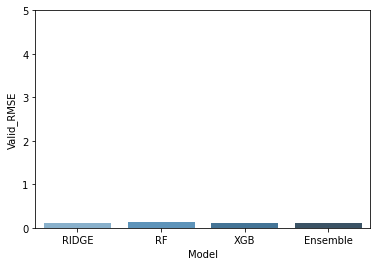

In [118]:
rmse_valid = [rmse_va_ridge, rmse_va_rf, rmse_va_xgb, rmse_va_en]
recap_model = ['RIDGE', 'RF', 'XGB', 'Ensemble']
df_recap = pd.DataFrame({'Model': recap_model, 'Valid_RMSE' : rmse_valid})
ax = sns.barplot(x='Model', y='Valid_RMSE', data=df_recap, palette="Blues_d")
ax.set_ylim([0, 5]) 

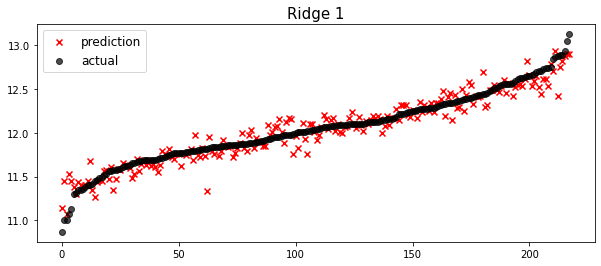

,model,error
0,Ridge 1,0.116619


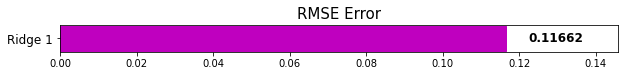

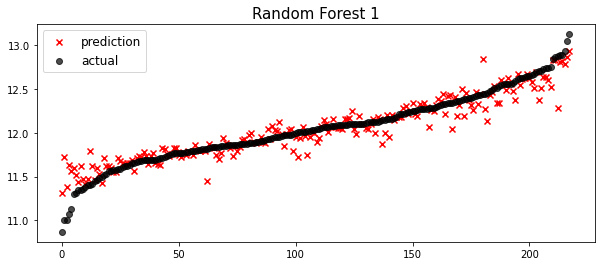

,model,error
0,Random Forest 1,0.140833
1,Ridge 1,0.116619


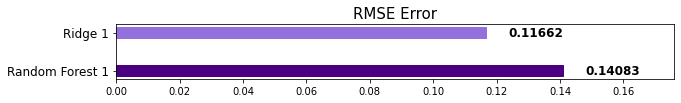

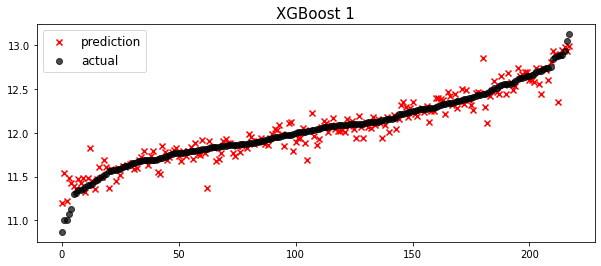

,model,error
0,Random Forest 1,0.140833
1,XGBoost 1,0.121379
2,Ridge 1,0.116619


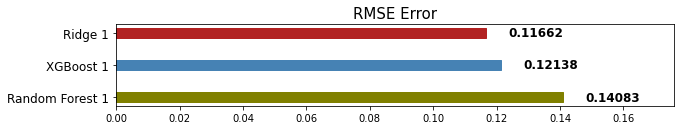

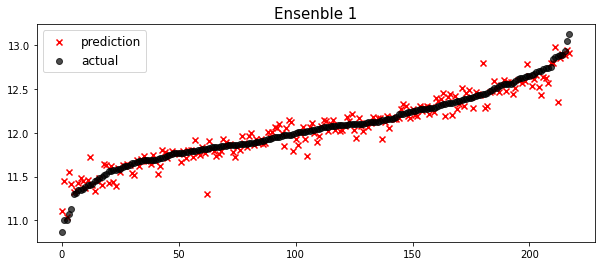

,model,error
0,Random Forest 1,0.140833
1,XGBoost 1,0.121379
2,Ridge 1,0.116619
3,Ensenble 1,0.113085


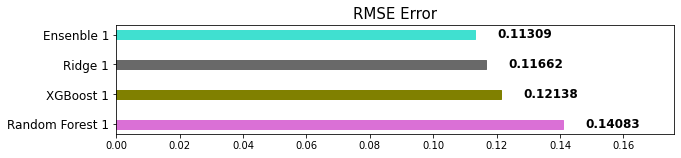

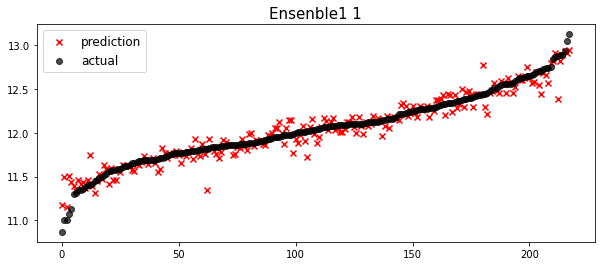

,model,error
0,Random Forest 1,0.140833
1,XGBoost 1,0.121379
2,Ridge 1,0.116619
3,Ensenble 1,0.113085
4,Ensenble1 1,0.112103


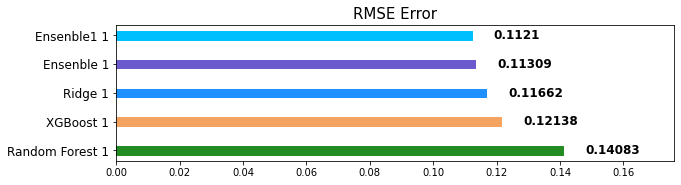

In [119]:
utils.plot_error('Ridge '+ str(trynum), y_ridge_valid, y_pred_va_ridge)
utils.plot_error('Random Forest ' + str(trynum), y_rf_valid, y_pred_va_rf)
utils.plot_error('XGBoost ' + str(trynum), y_xgb_valid, y_pred_va_xgb)
utils.plot_error('Ensenble ' + str(trynum), y_xgb_valid, y_pred_va_en)
utils.plot_error('Ensenble1 ' + str(trynum), y_rf_valid, y_pred_va_en1)

## 6. 결과제출(sumission)

### 6.1 예측값 저장하기 ( 지수함수 변환 포함 )

In [120]:
# Log 함수 결과값을 원래의 값으로 환원하기 : np.expm1(b)
print(y_pred_te_en, np.expm1(y_pred_te_en))

[11.71116044 11.97019421 12.1335298  ... 11.94362335 11.67319481
 12.38888794] [121923.88499306 157974.33826628 186004.17998935 ... 153832.07249766
 117381.69969559 240117.52655895]


In [121]:
test['SalePrice'] = list(np.expm1(y_pred_te_en))
df_submission = test[['Id', 'SalePrice']] 
df_submission.head()

,Id,SalePrice
0,1461,121923.884993
1,1462,157974.338266
2,1463,186004.179989
3,1464,202131.277216
4,1465,189488.822534


In [122]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

Id           0
SalePrice    0
dtype: int64

In [123]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(test)
print(f'No. of Predict DataSet : {len(test)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 1459
No. of Submission DataSet : 1459


### 6.2 Predict Outlier 보정하기

In [124]:
# Predict Outlier 보정하기 - 양극단 데이타 보정하기
q1 = df_submission['SalePrice'].quantile(0.0045)
q2 = df_submission['SalePrice'].quantile(0.99)
print(q1, q2)

62358.63085955865 406910.5923456379


In [125]:
df_submission['SalePrice'] = df_submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
df_submission['SalePrice'] = df_submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

### 6.3 결과파일 저장하기

In [126]:
# 예측 파일을 저장합니다. 
df_submission.set_index('Id', inplace=True)
df_submission.to_csv(f'submission.csv')